### Generalized additive model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Import the dataset

In [2]:
washingtonDcSviRaw = gpd.read_file('./data/processed data/SVI2020 WashingtonDC counties with death rate/SVI2020_WashingtonDC_counties_with_death_rate.shp')

In [3]:
# reaname od_deaths_ column to deaths_rate
washingtonDcSviRaw = washingtonDcSviRaw.rename(columns={'od_deaths_':'death_rate'})

##### Filtering the raw variables with overdose death rate

In [4]:
selectedVariables = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','death_rate']

In [5]:
selectedVariablesWithoutY = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ']

In [6]:
# filter metro_svi_deaths dataframe to include only the selected variables and od_deaths_per_1000
metroSviMultipleVariablesDf = washingtonDcSviRaw[selectedVariables]

In [7]:
metroSviMultipleVariablesDf.head(3)

EP_POV150  EP_UNEMP  EP_HBURD  EP_NOHSDP  EP_UNINSUR  EP_AGE65  EP_AGE17  \
0       21.3       7.1      27.2        8.1         3.7      12.2      18.0   
1        8.0       3.8      19.0        5.7         3.3      14.9      23.2   
2       10.9       4.4      21.8        6.4         4.2      12.5      24.0   

   EP_DISABL  EP_SNGPNT  EP_LIMENG  EP_MINRTY  EP_MUNIT  EP_MOBILE  EP_CROWD  \
0       11.4        6.9        2.4       63.3      46.8        0.1       3.6   
1        9.9        4.6        0.3       22.4       3.7        0.9       0.5   
2        9.9        8.2        1.0       61.7       5.8        0.9       1.8   

   EP_NOVEH  EP_GROUPQ  death_rate  
0      35.4        5.6    0.615407  
1       2.8        0.6    0.358330  
2       3.2        1.3    0.371637

In [32]:
#define predictor and response variables
X = metroSviMultipleVariablesDf.drop('death_rate', axis=1)
y = metroSviMultipleVariablesDf['death_rate']

In [33]:
from pygam import LinearGAM

In [42]:
# gam = LinearGAM(n_splines=25).gridsearch(X.values, y.values)

In [34]:
gam = LinearGAM().fit(X.values, y.values)

In [35]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.0356
Link Function:                     IdentityLink Log Likelihood:                                  -249.4827
Number of Samples:                           25 AIC:                                              517.0367
                                                AICc:                                             529.1559
                                                GCV:                                                  0.06
                                                Scale:                                              0.0268
                                                Pseudo R-Squared:                                   0.4676
Feature Function                  Lam

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_26791/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


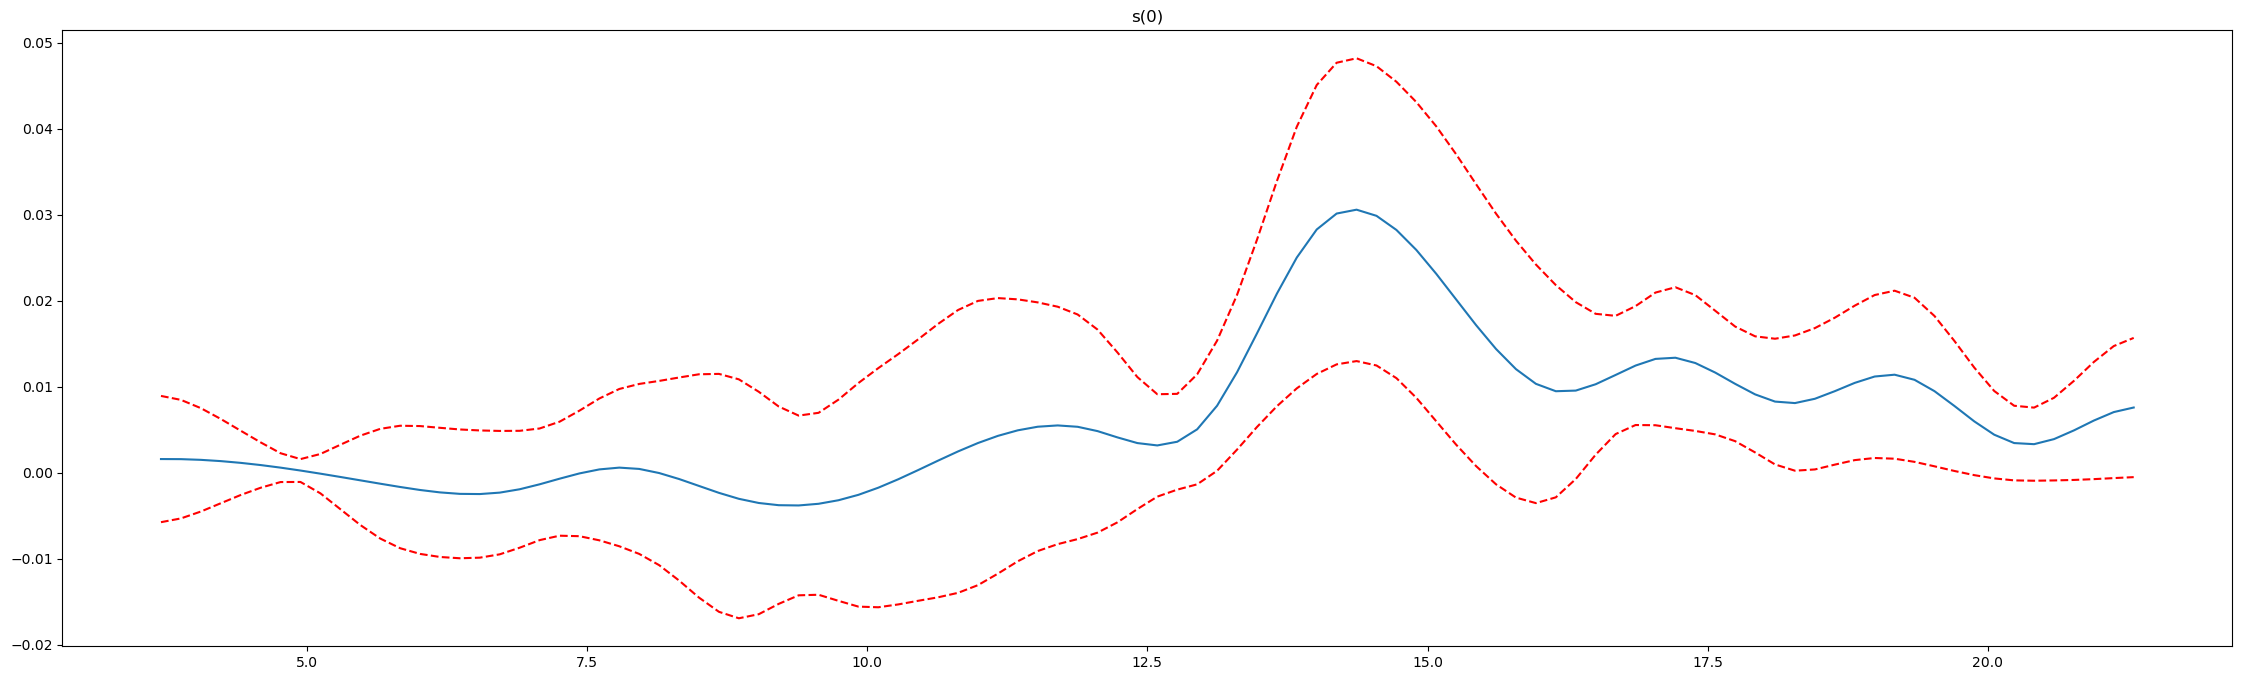

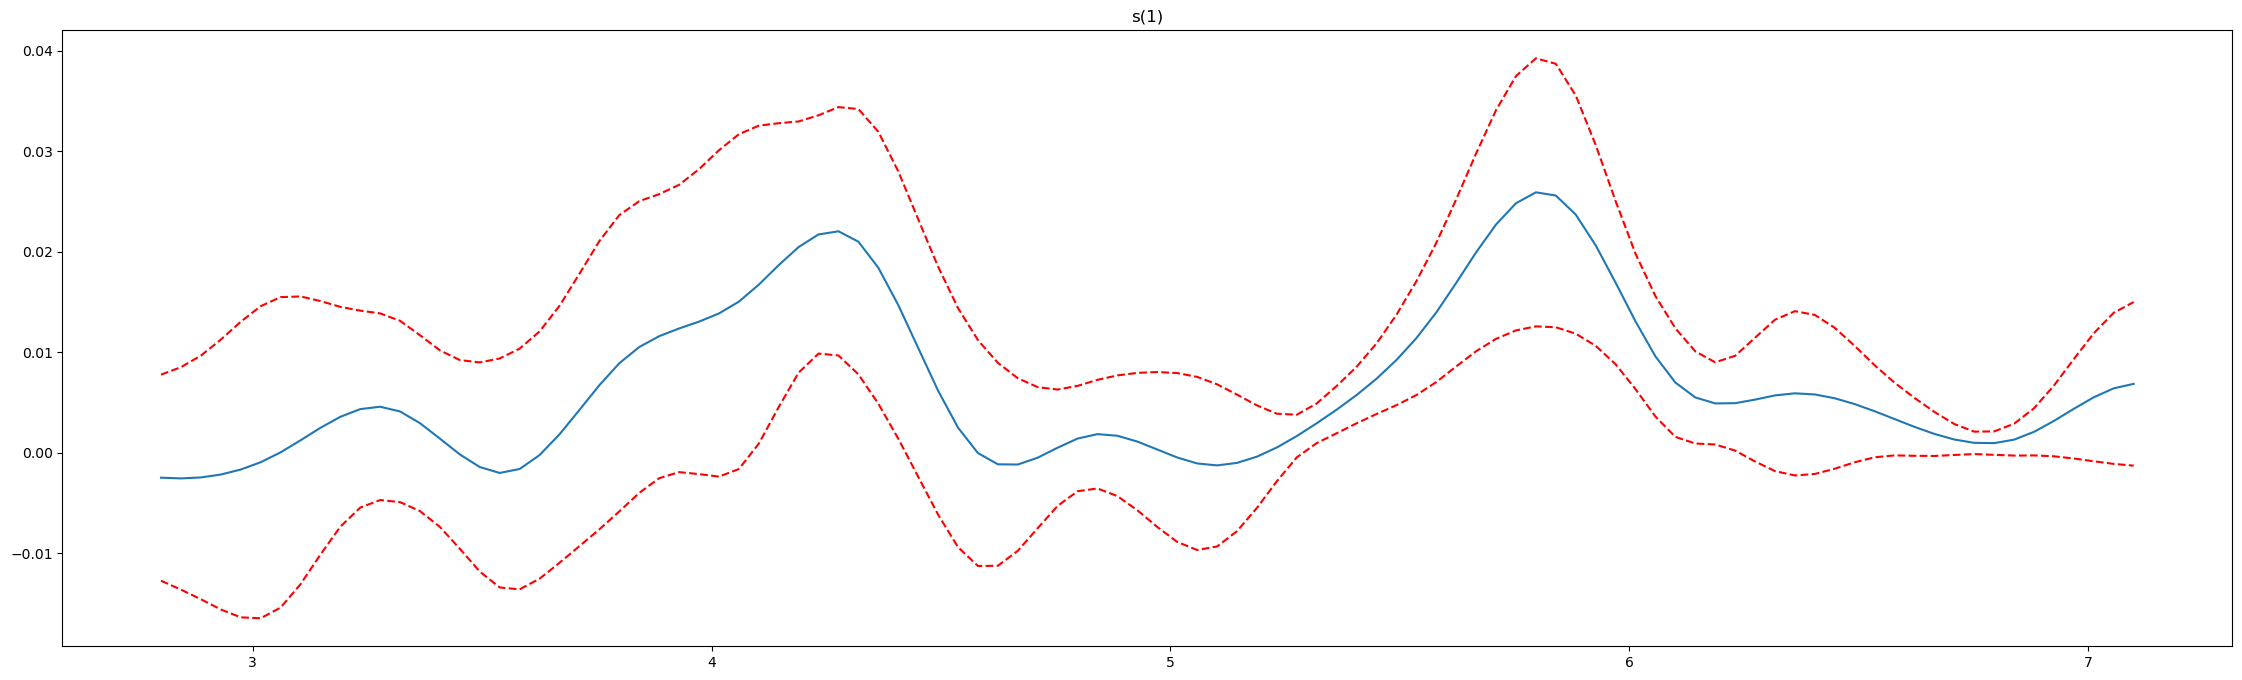

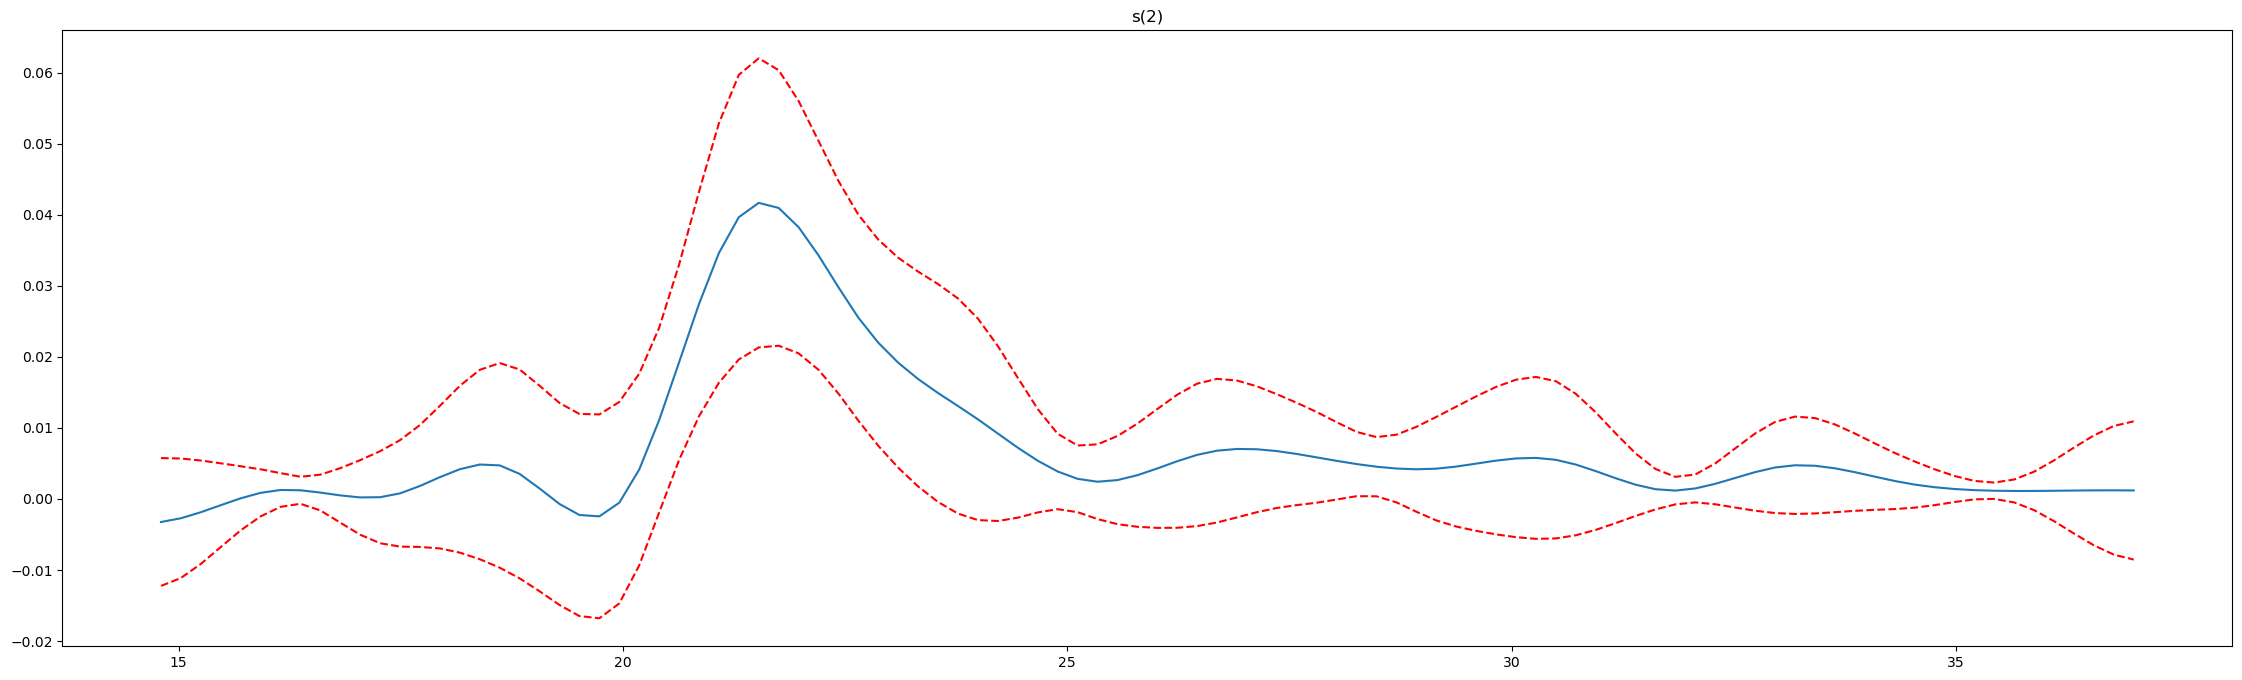

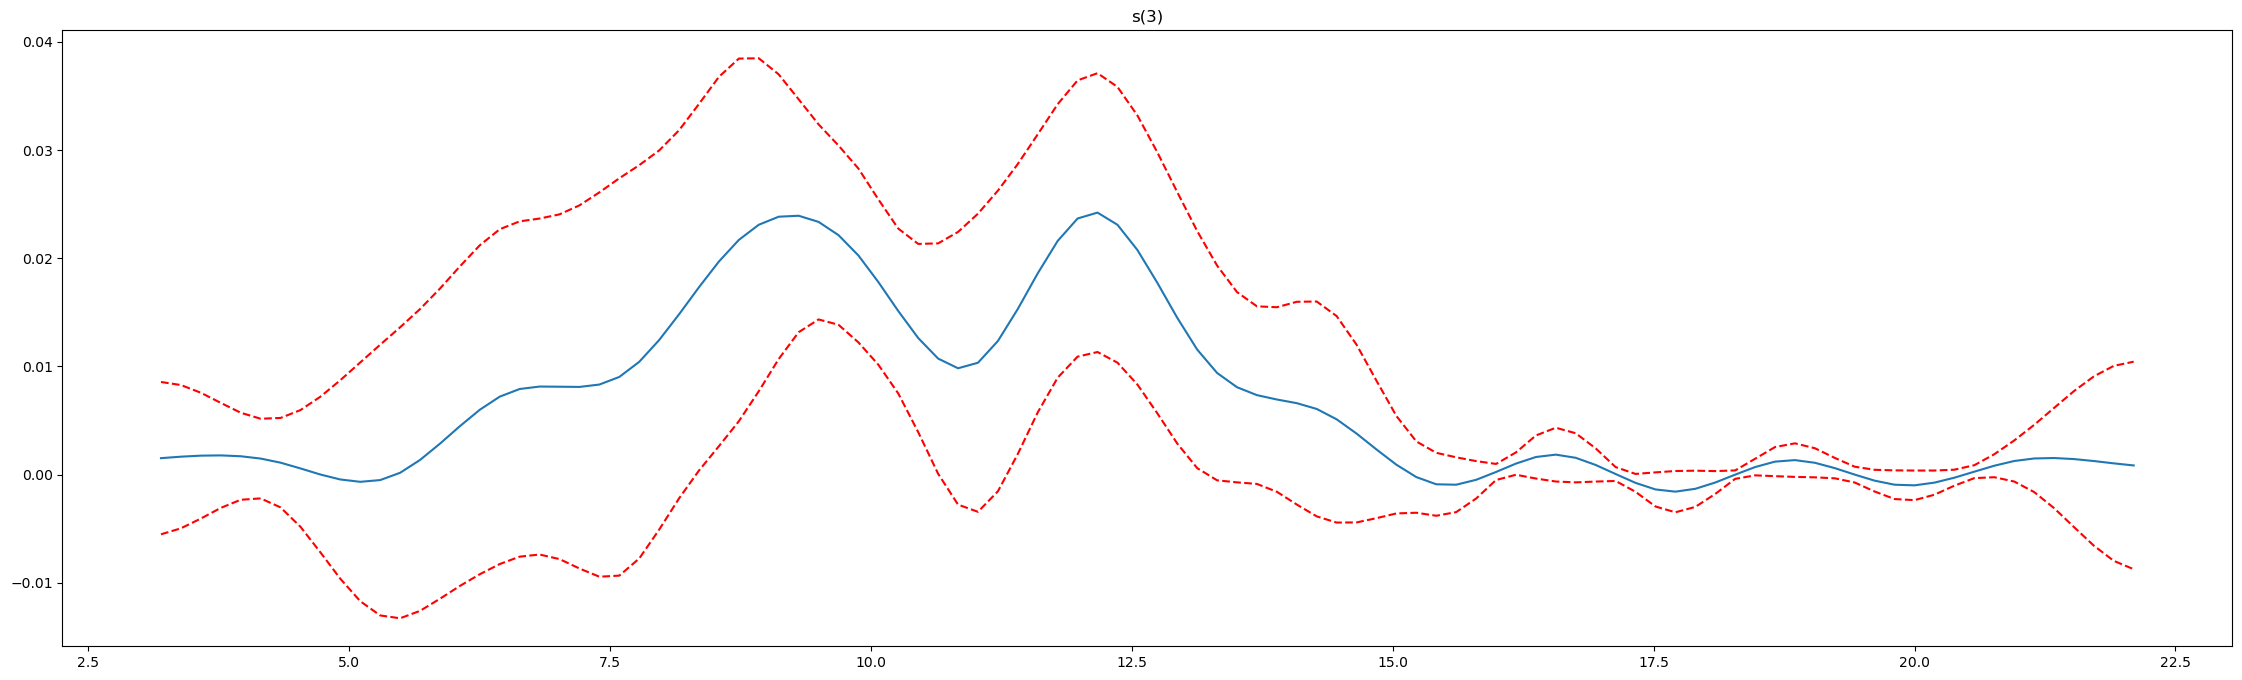

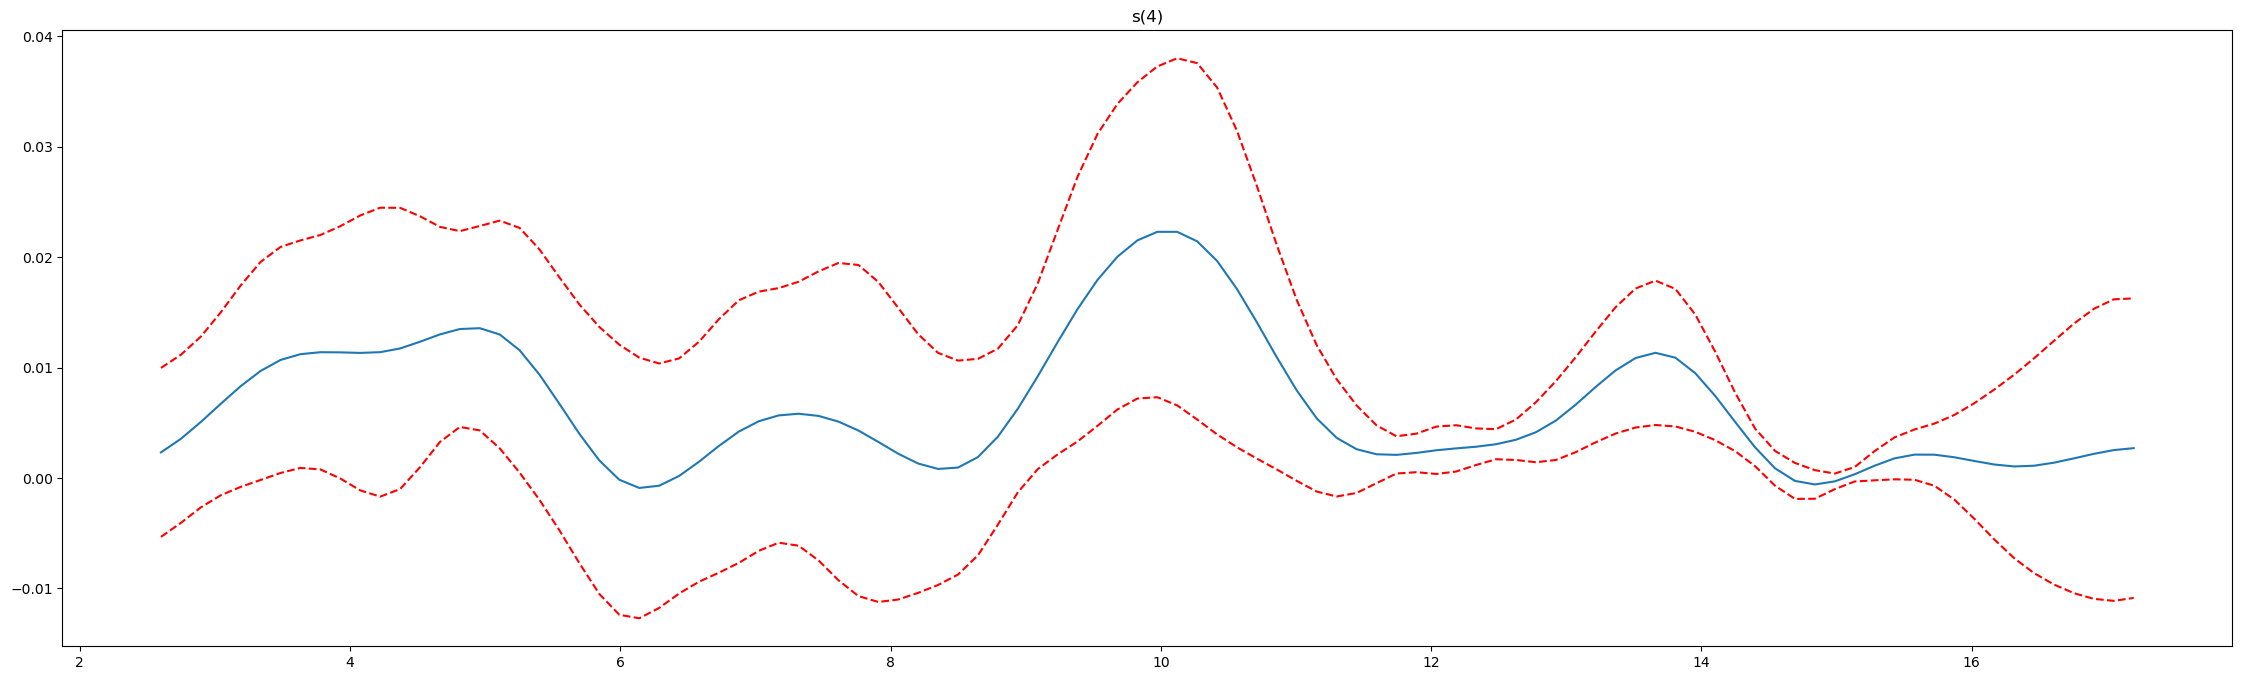

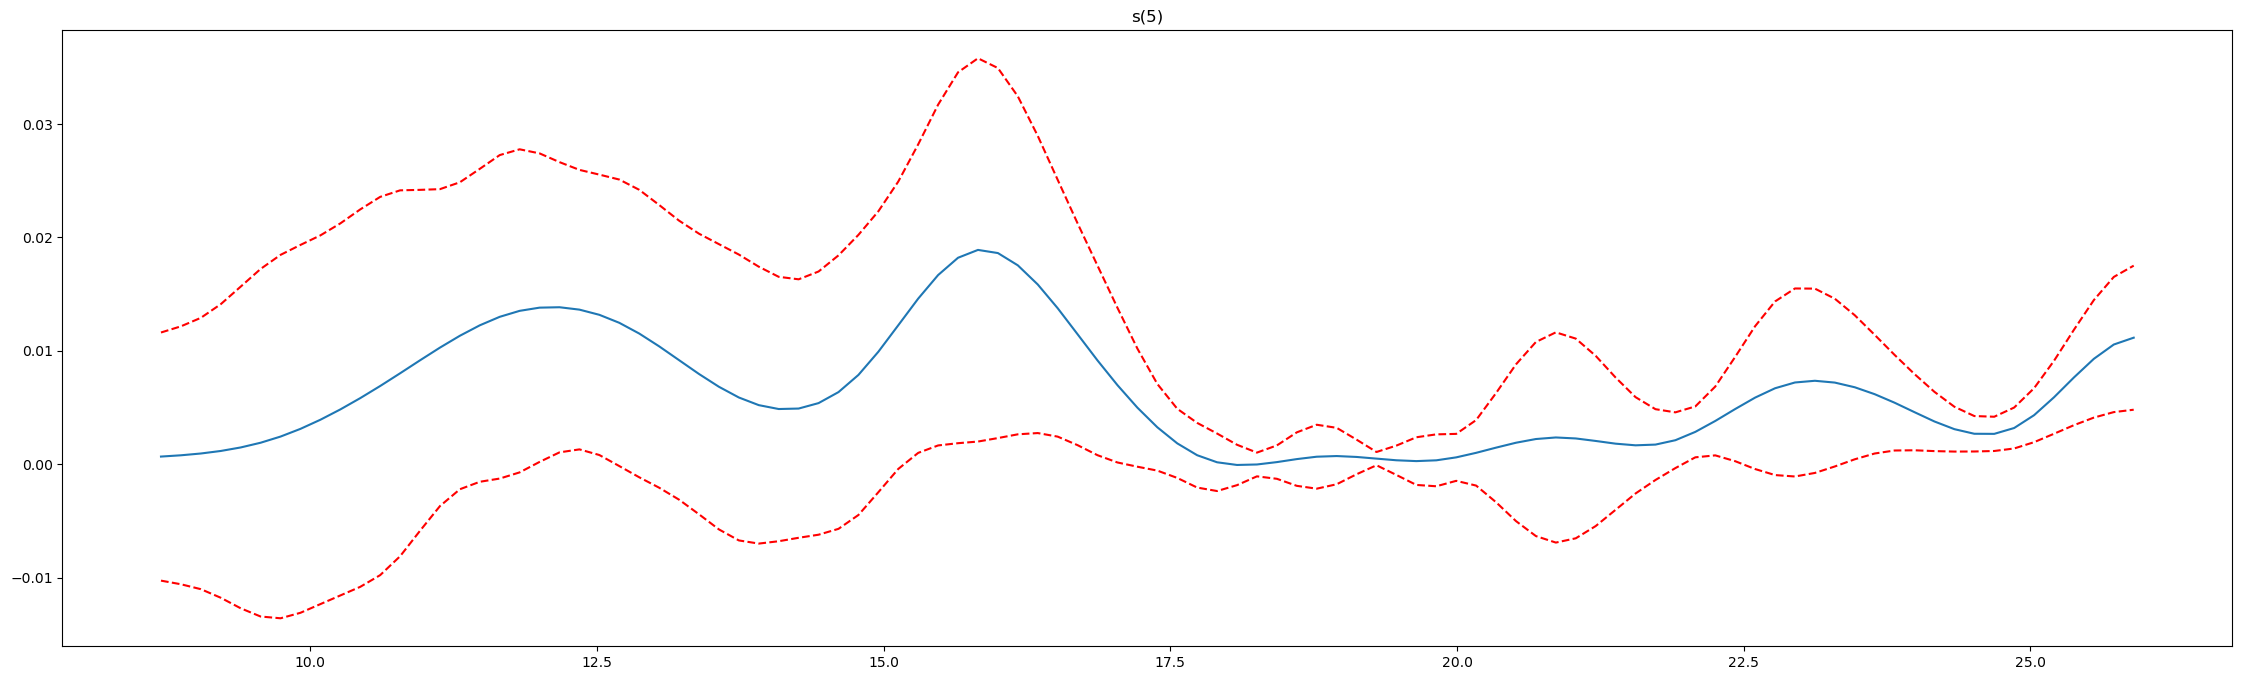

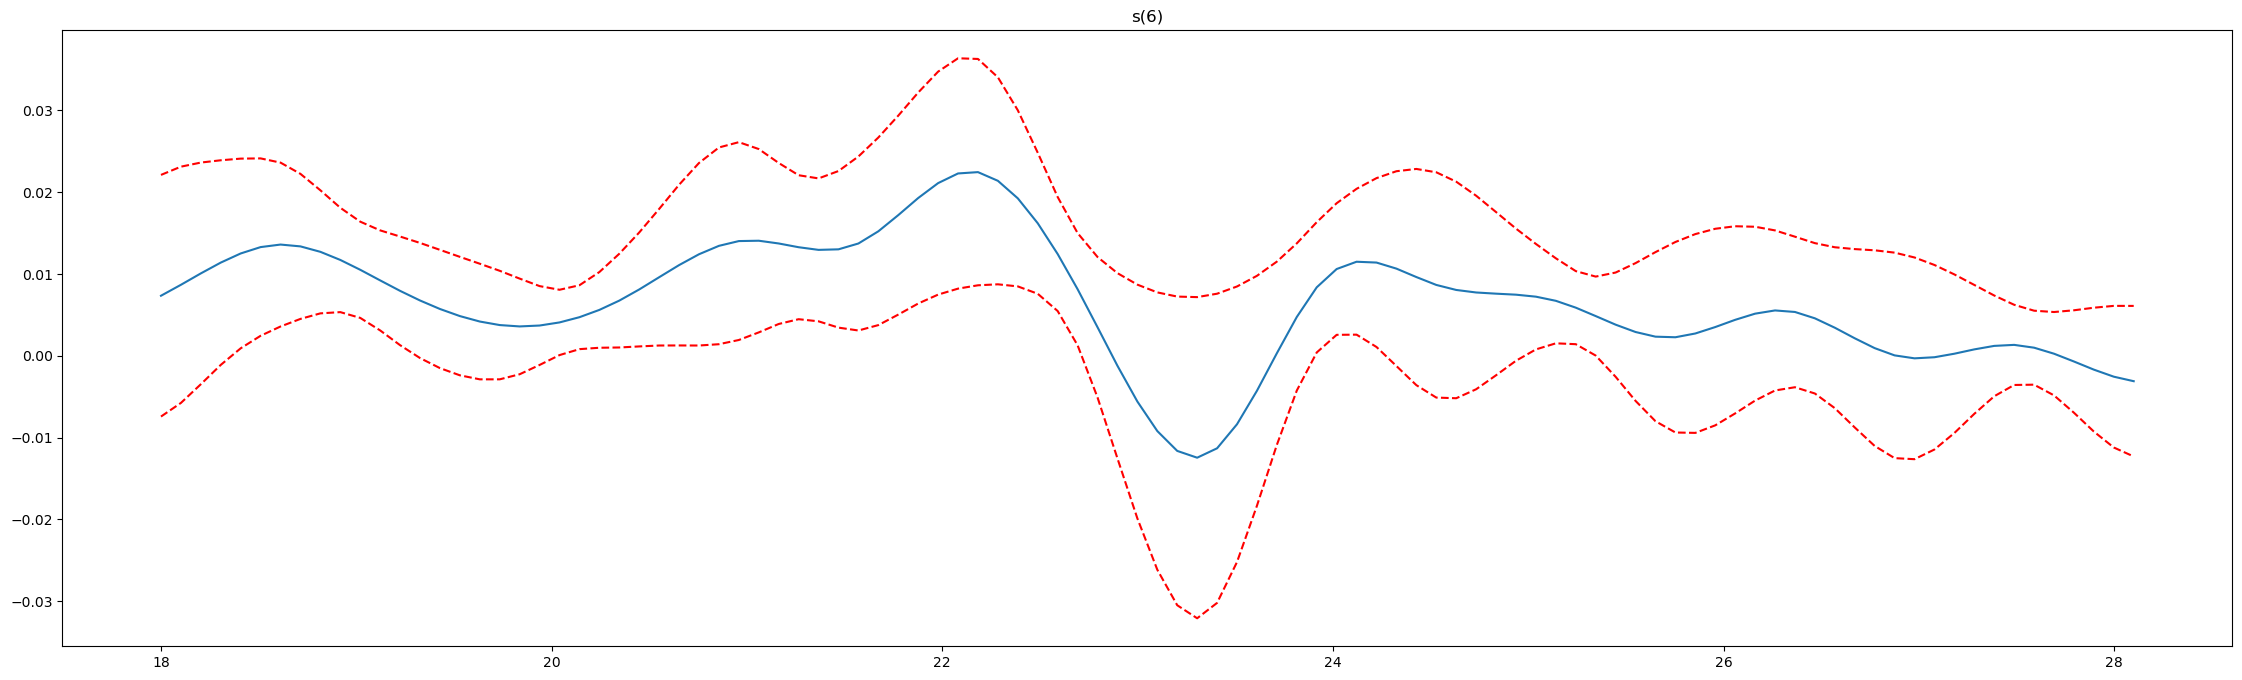

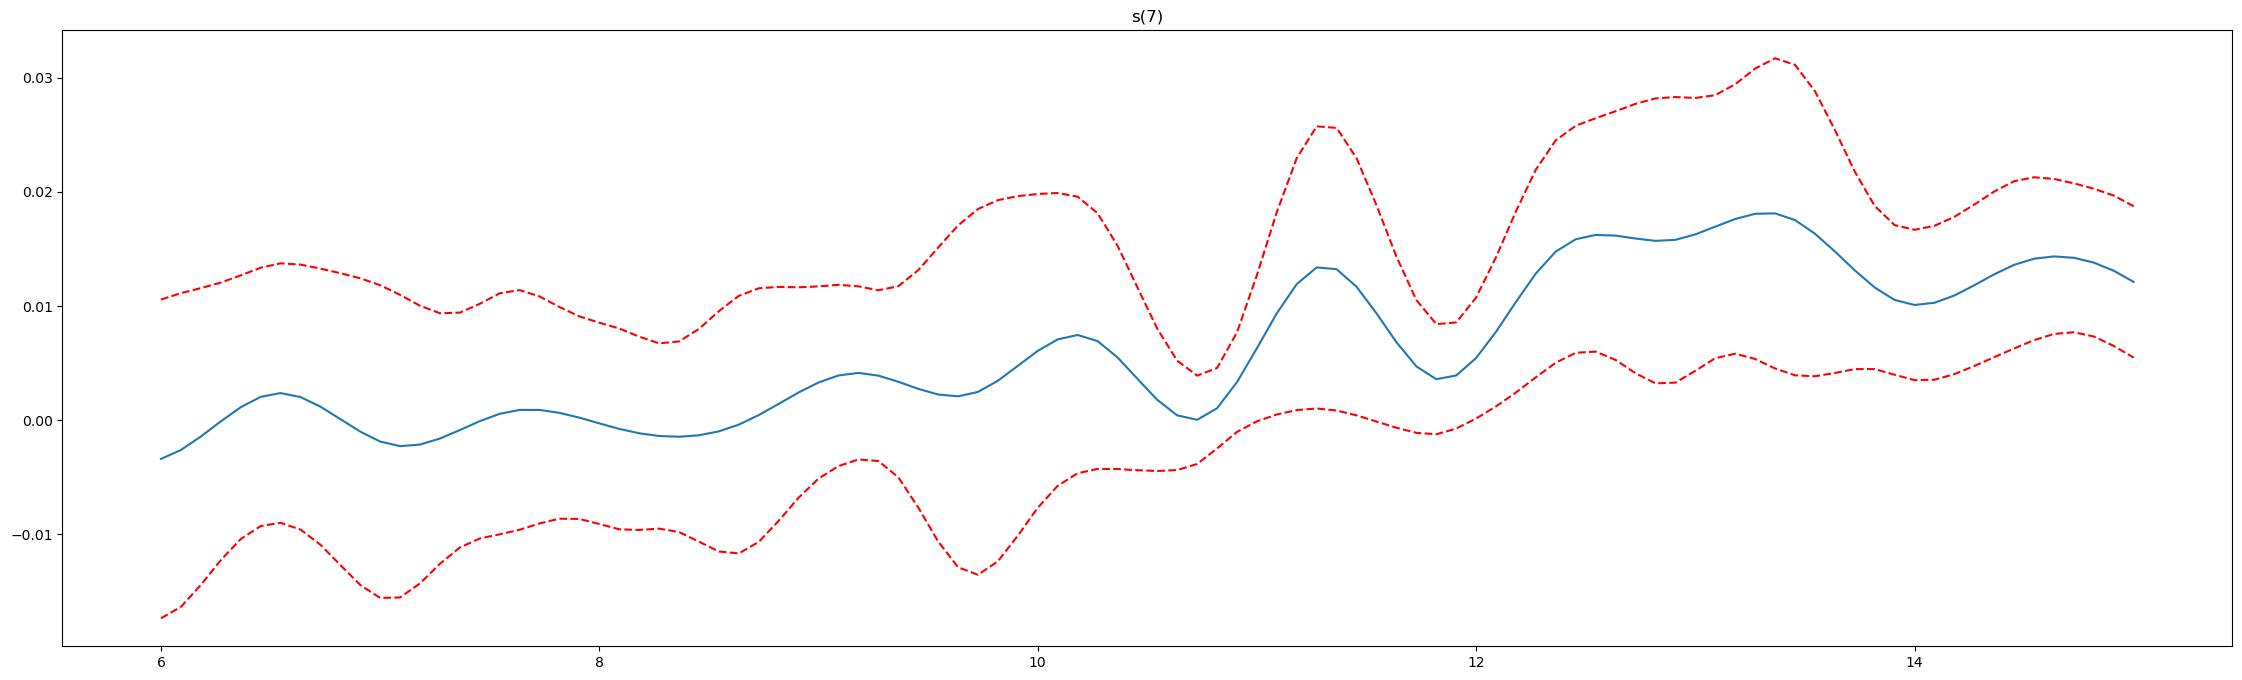

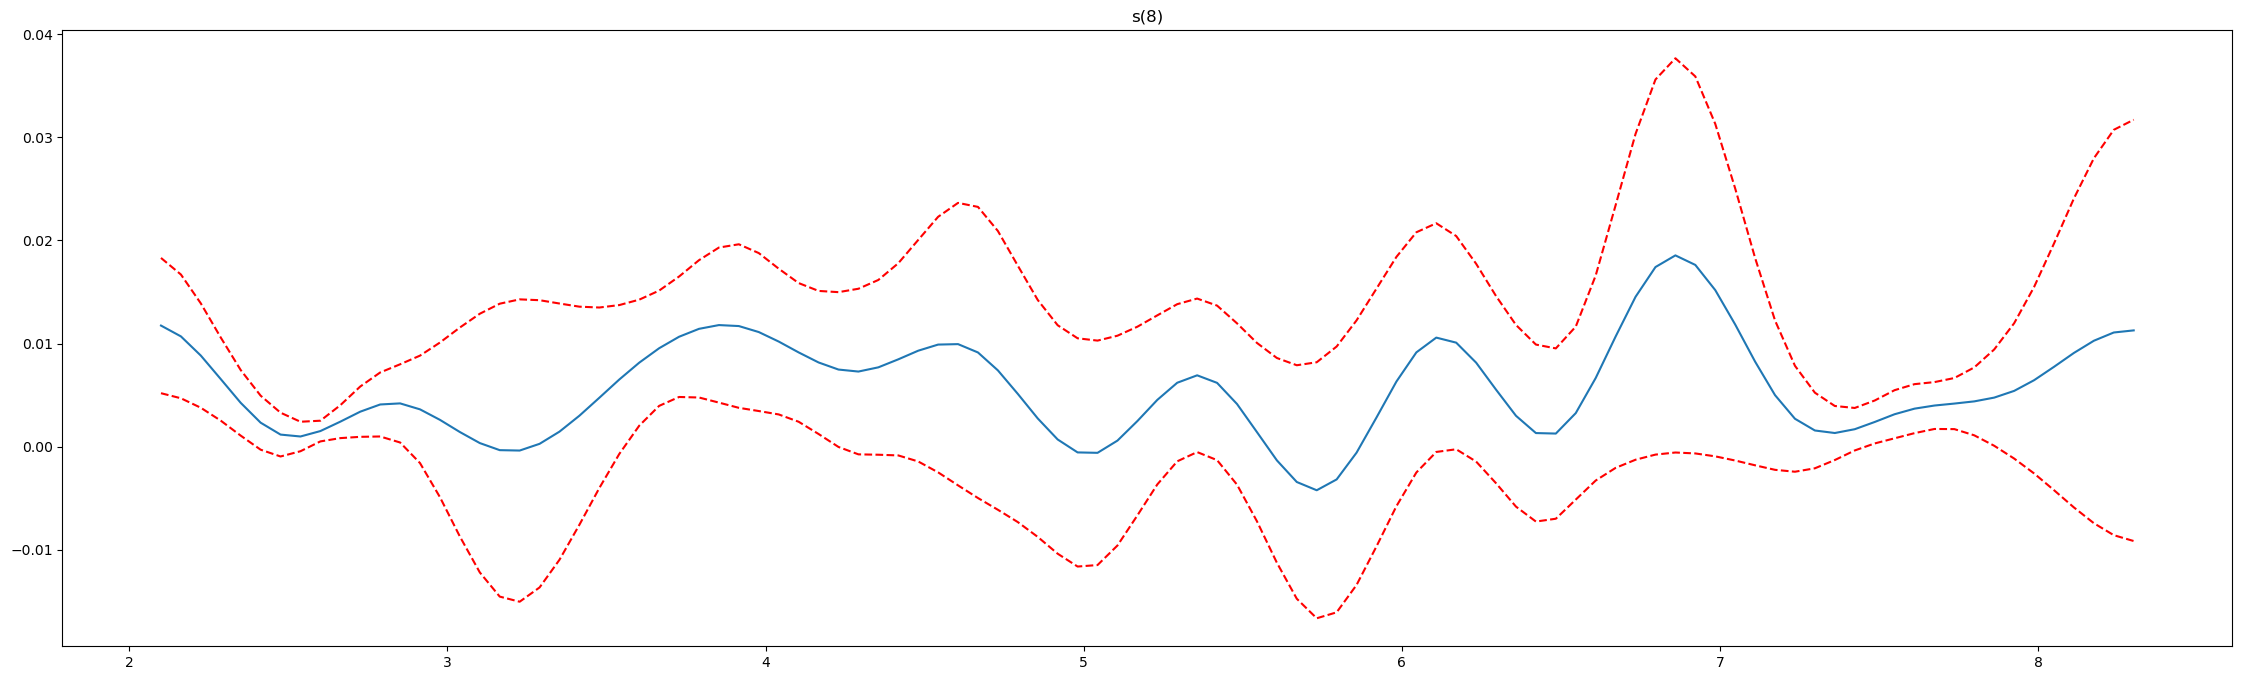

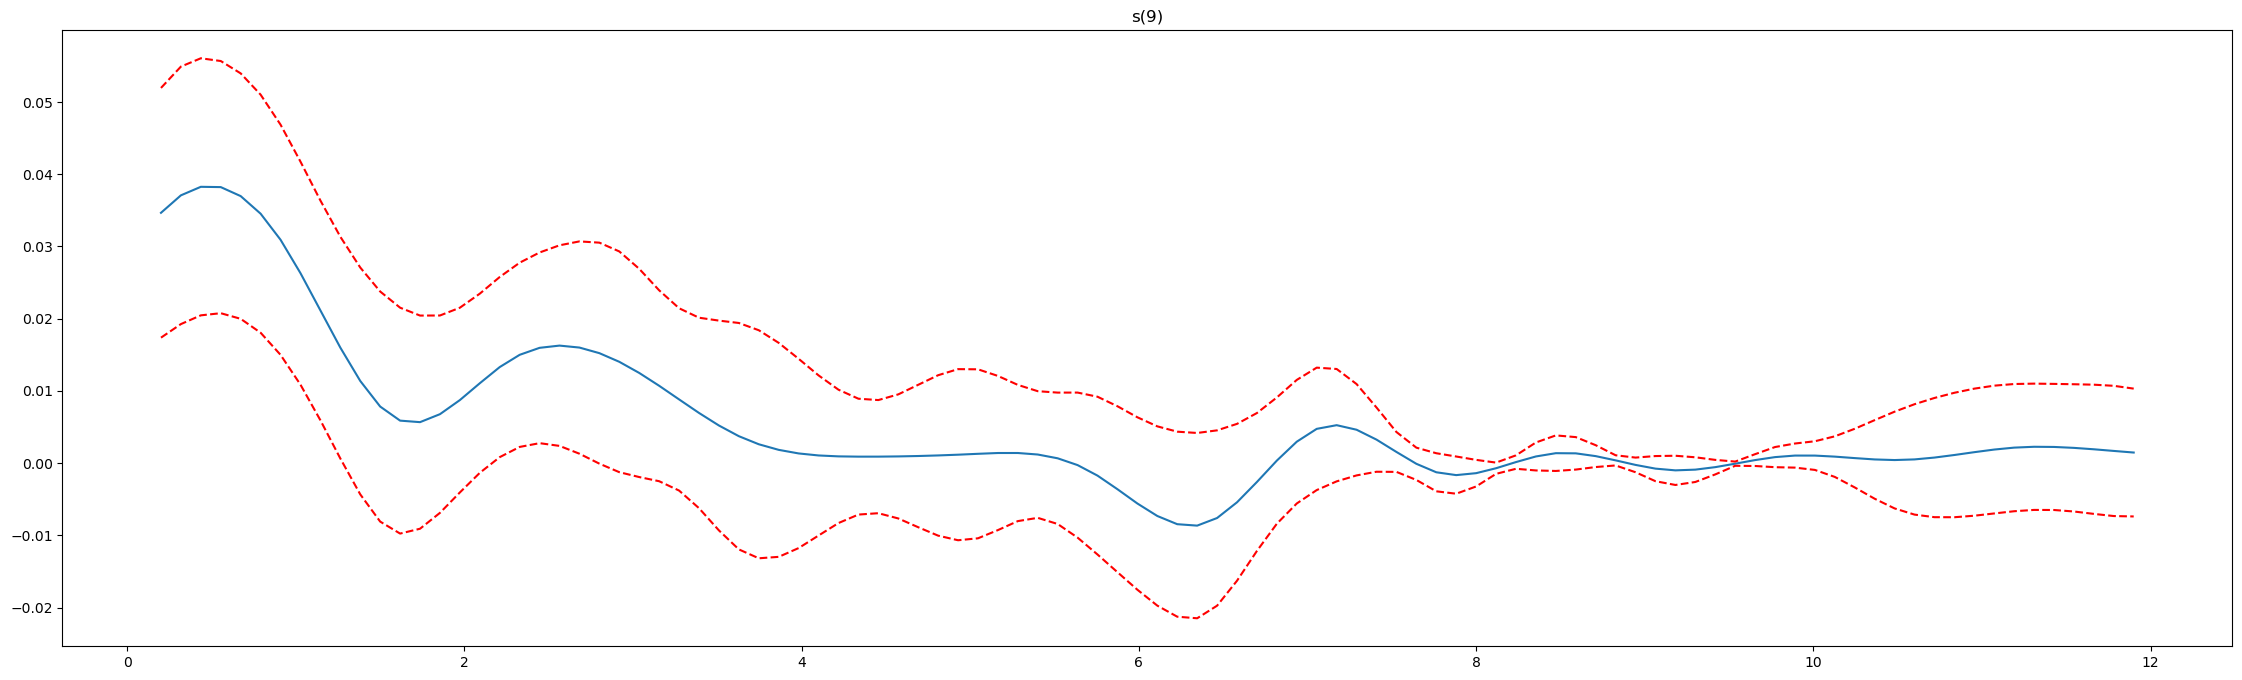

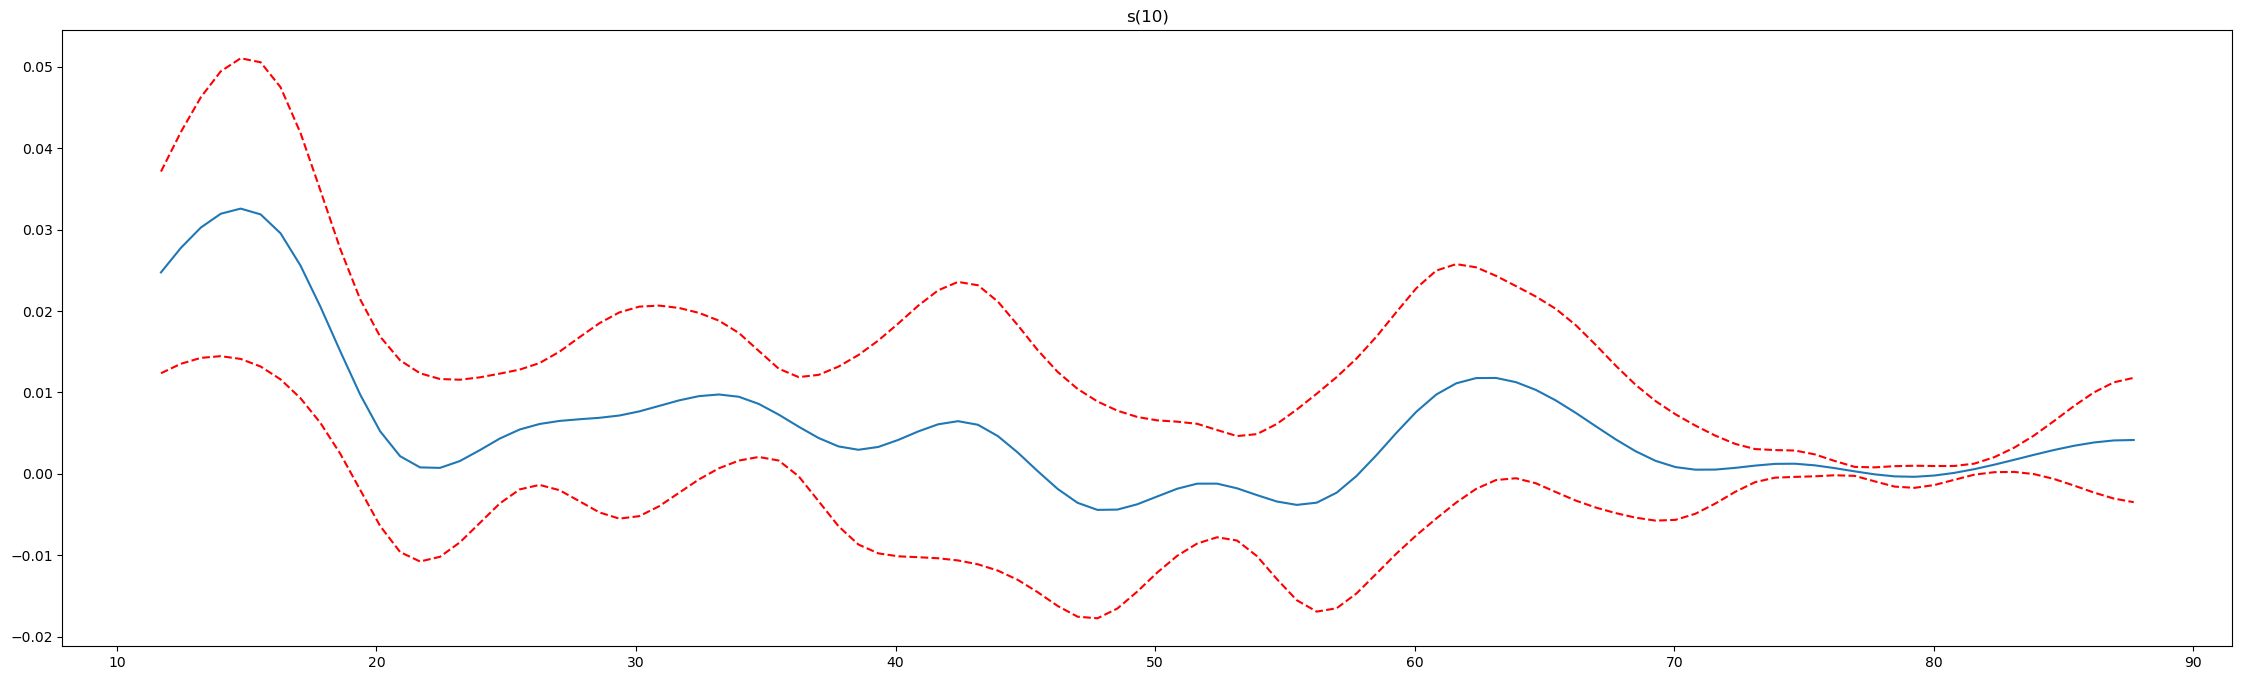

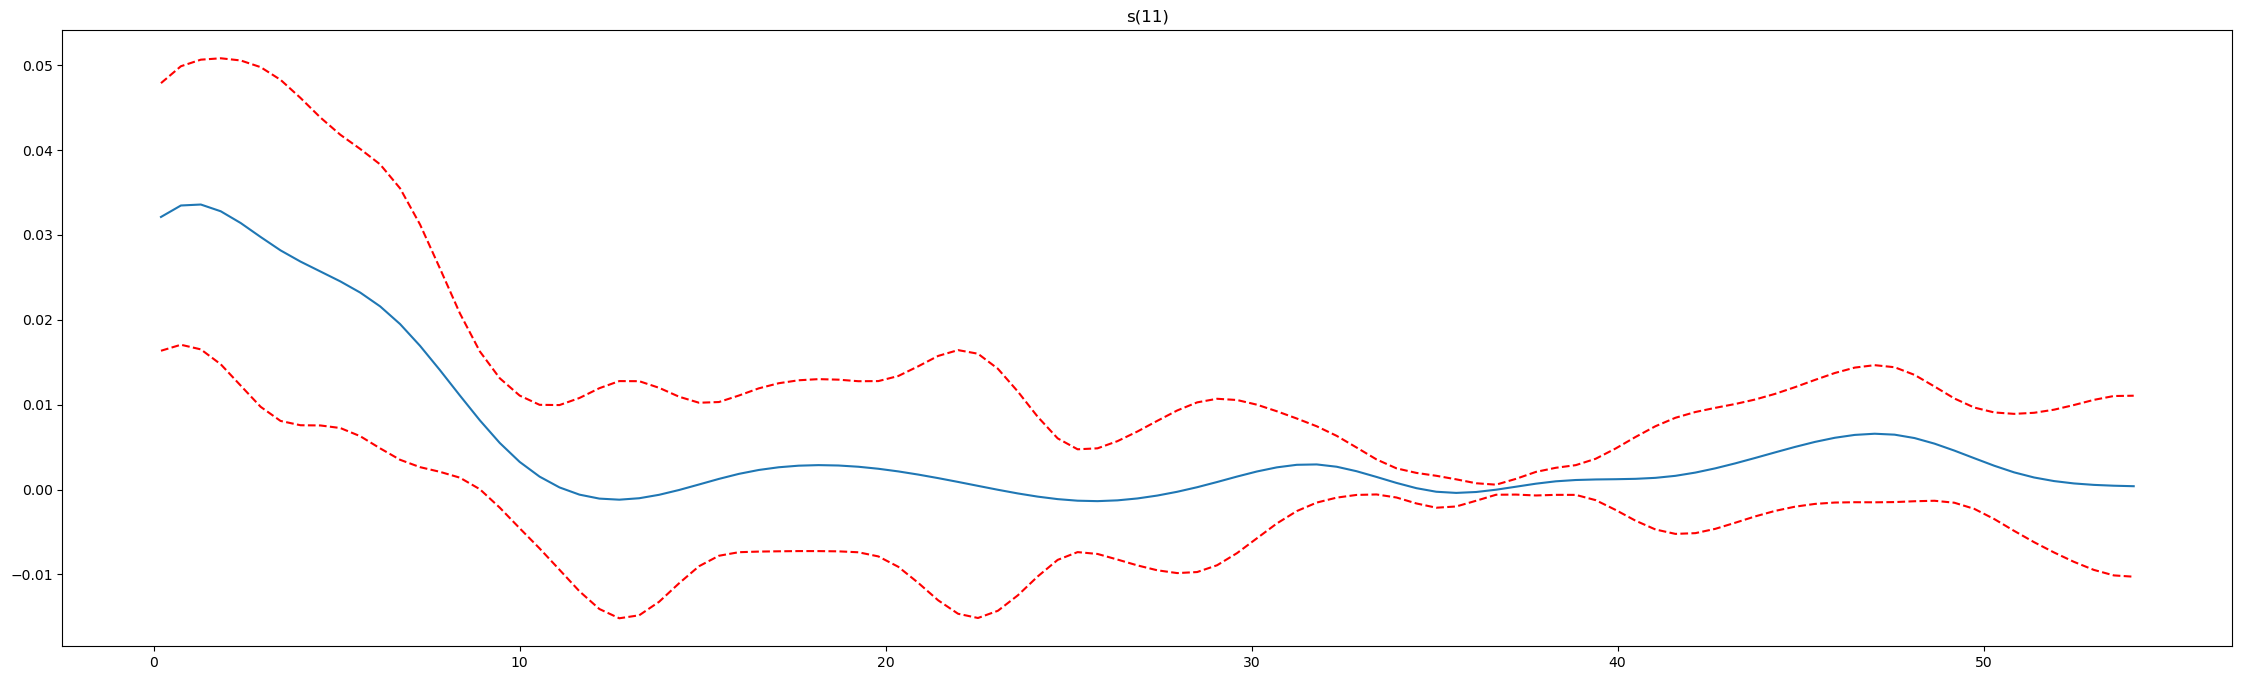

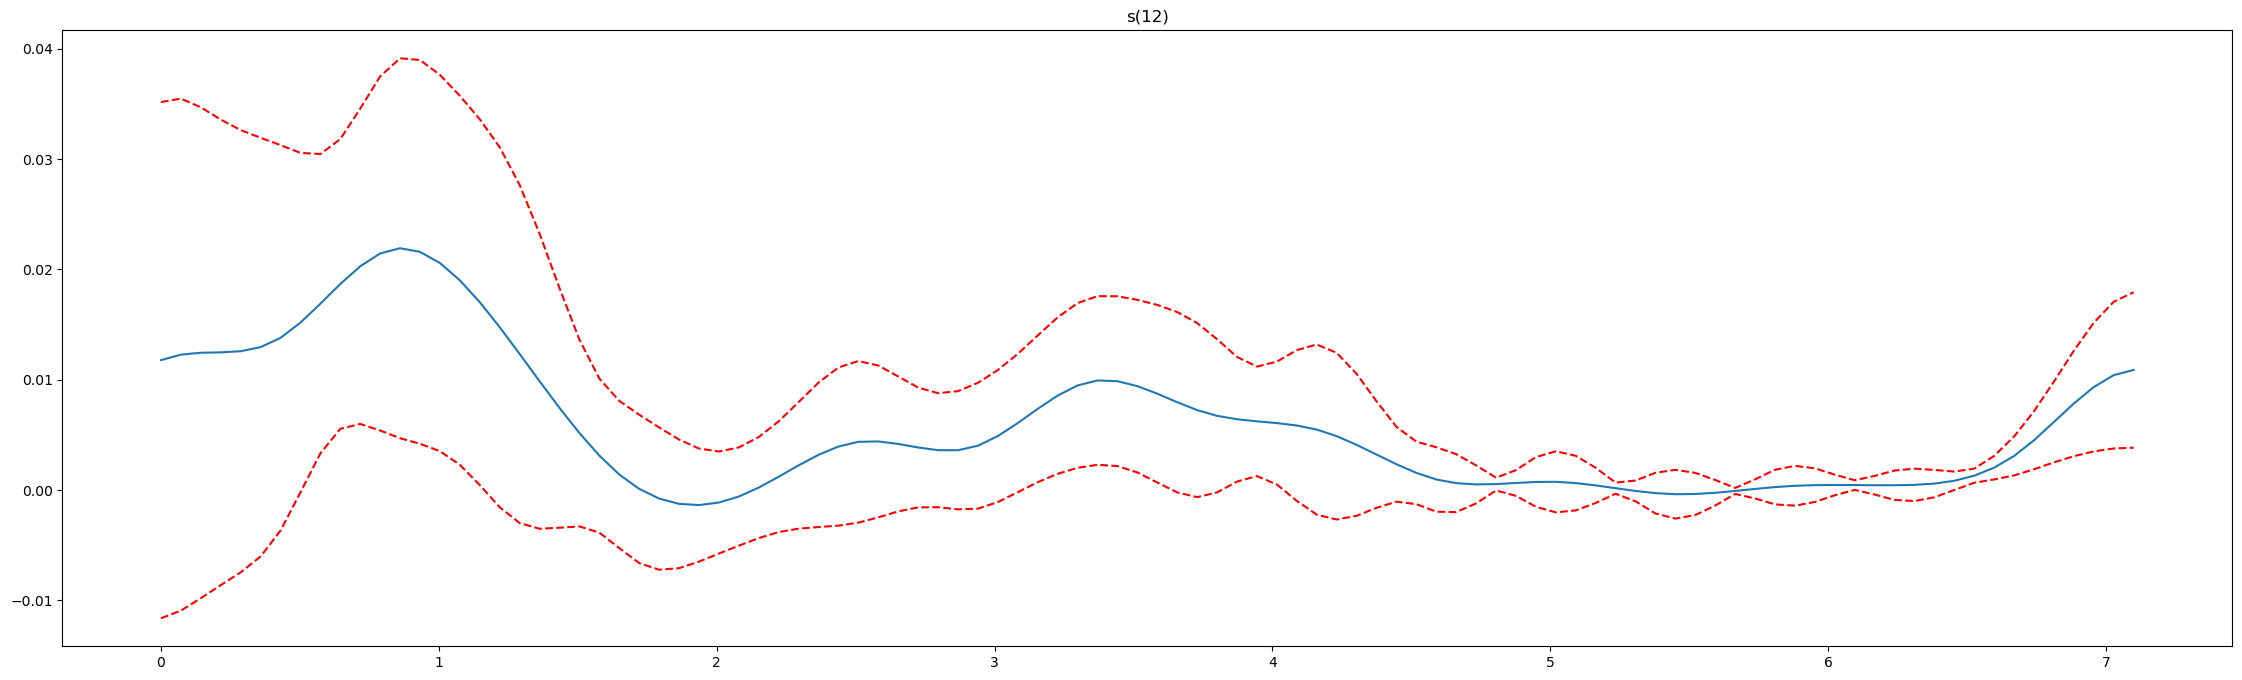

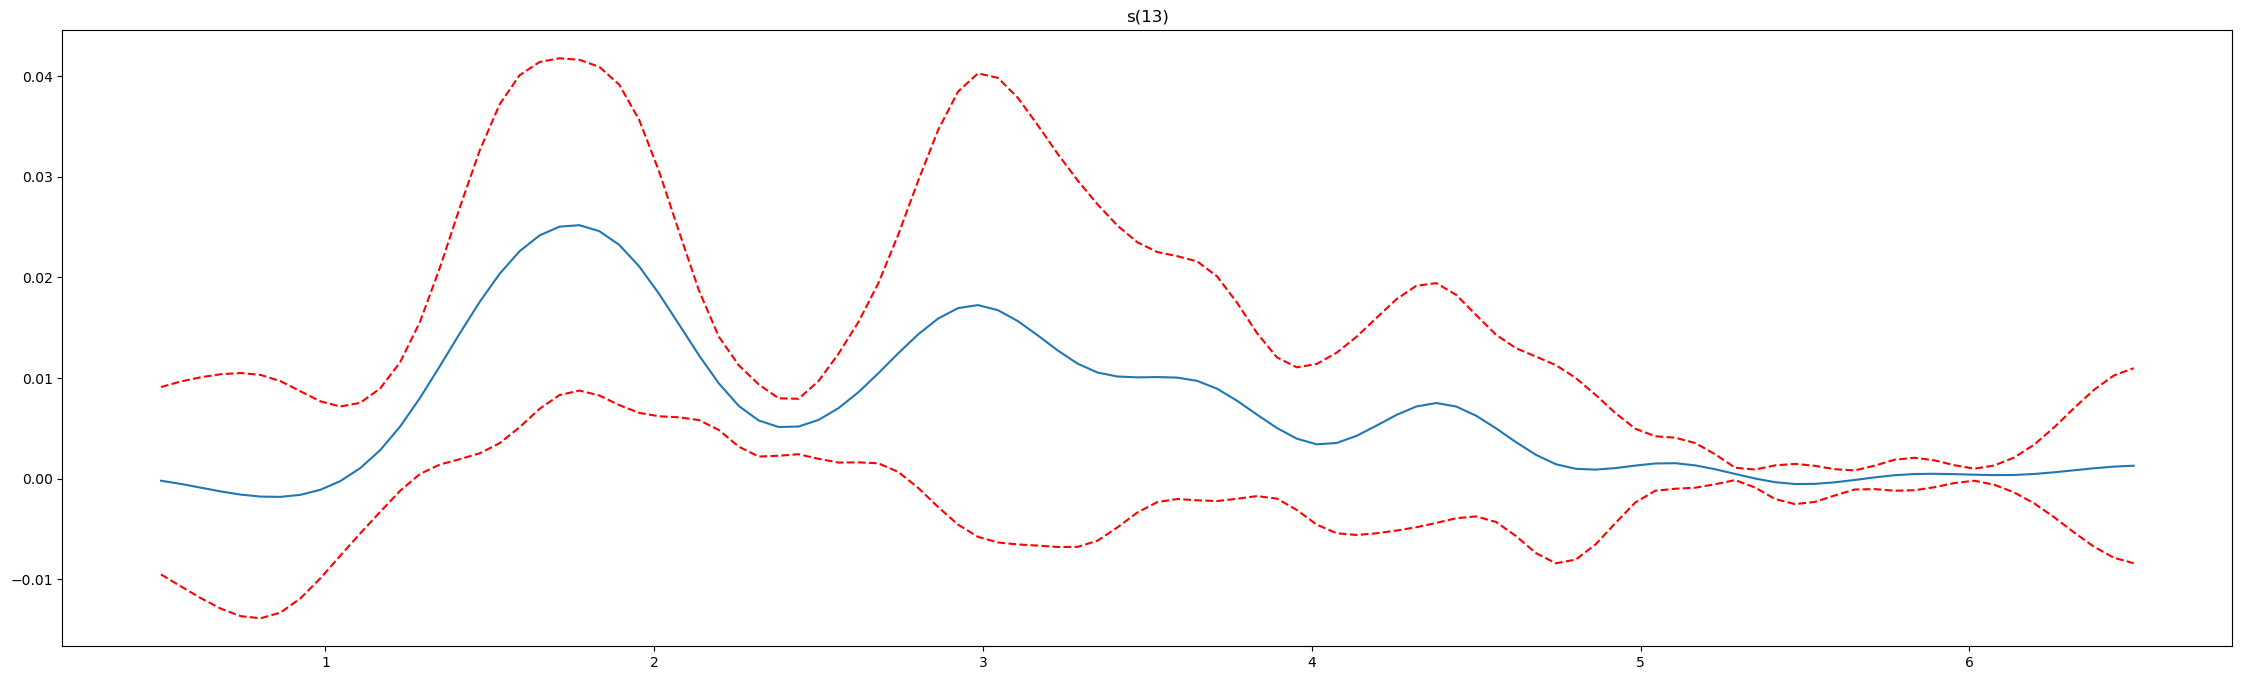

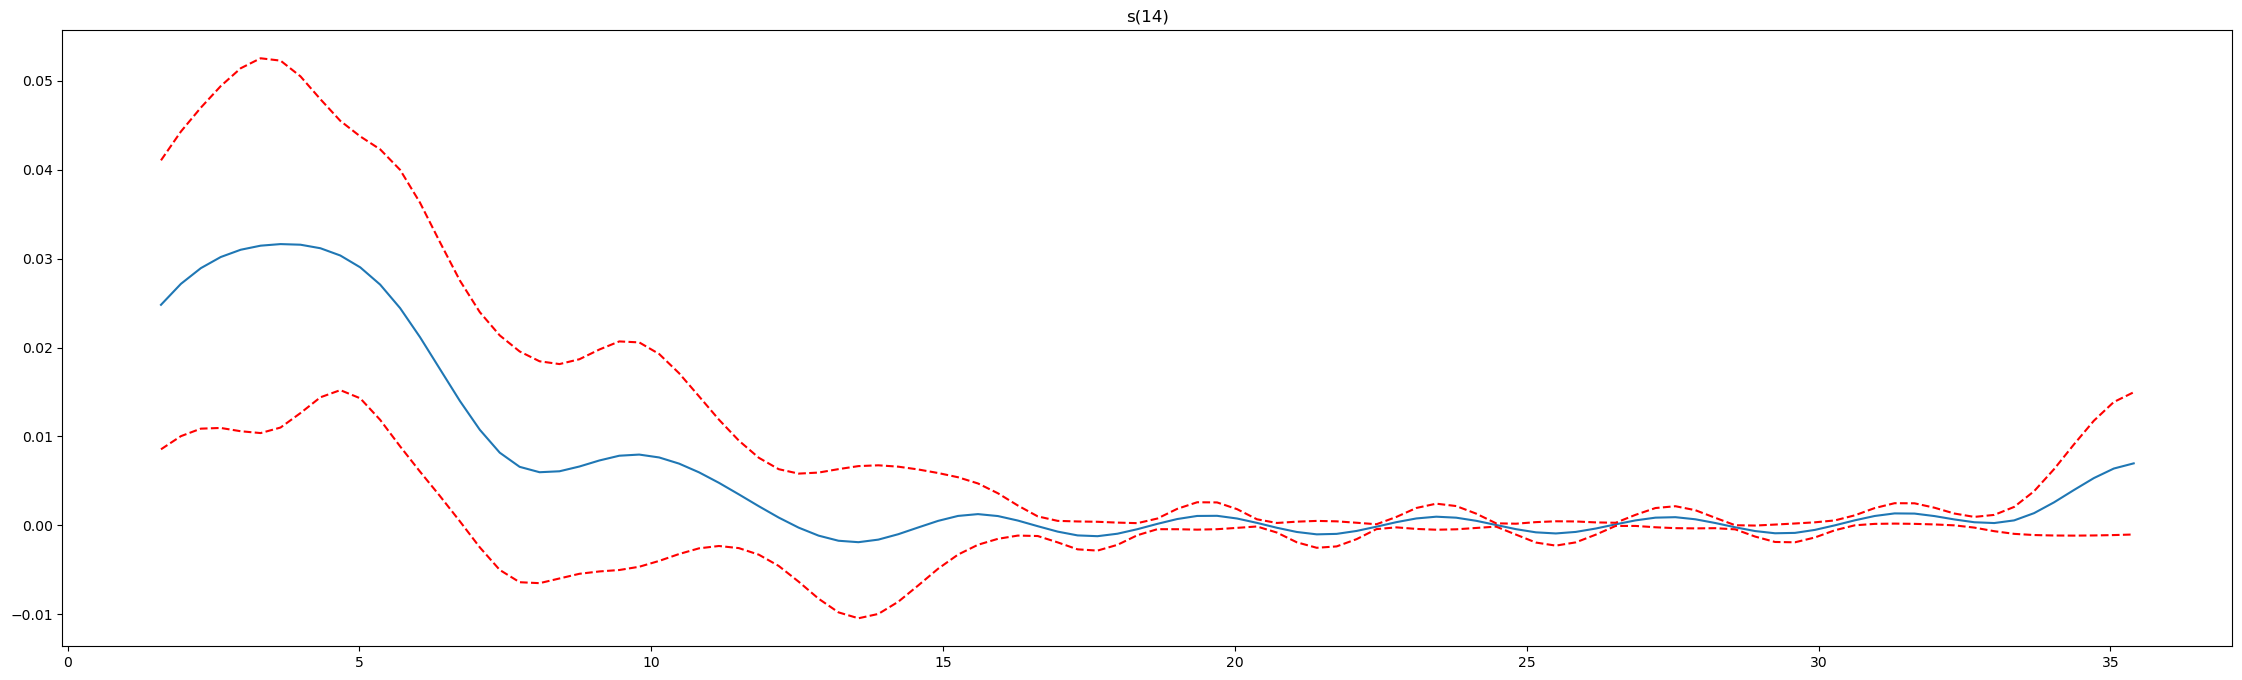

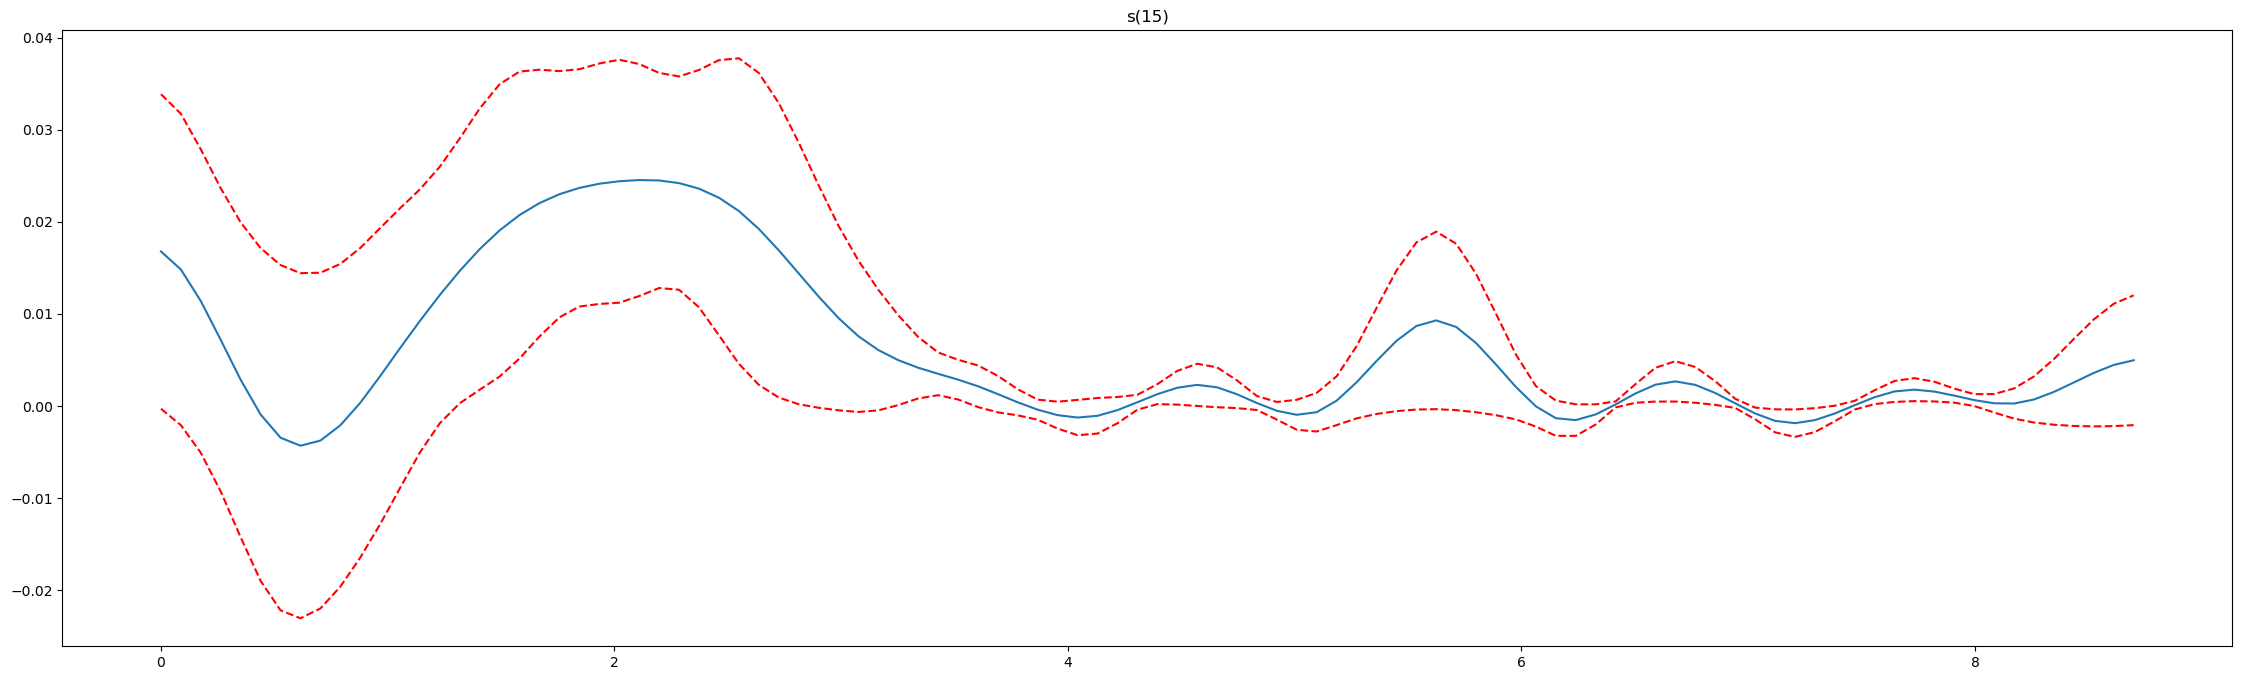

In [36]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

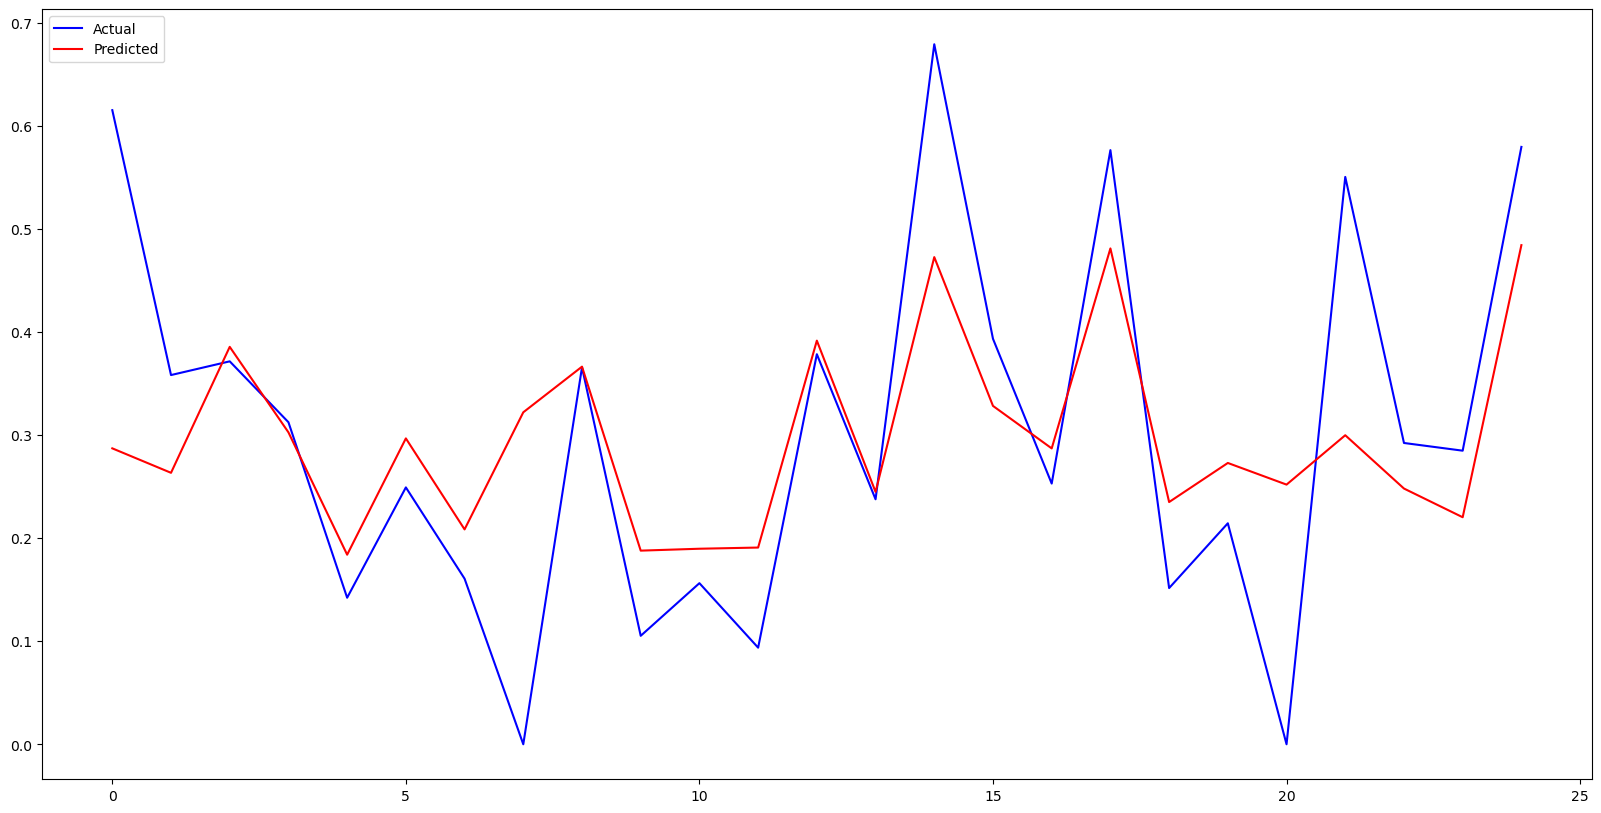

In [41]:
# plot both actual and predicted values on the same graph
y.plot(figsize=(20,10), color='blue', label='Actual')
plt.plot(gam.predict(X), color='red', label='Predicted')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#

## Smoothing

In [43]:
lams = np.logspace(-4, 0, 100)

In [47]:
gam = LinearGAM(n_splines=50).gridsearch(X.values, y.values, lam=lams)

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:01:36
  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:09
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:56
  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:00:48
  5% (5 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:45
  6% (6 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:44
  7% (7 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:33
  8% (8 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:34
  9% (9 of 100) |##                      | Elapsed Time: 0:00:04 ETA:   0:00:38
 10% (10 of 100) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:38
 11% (11 of 100) |##                     | Elapsed Time: 0:00:04 ETA:   0:00:38
 12% (12 of 100) |##                    

In [49]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     24.9991
Link Function:                     IdentityLink Log Likelihood:                                   -83.6299
Number of Samples:                           25 AIC:                                               219.258
                                                AICc:                                            -483.0095
                                                GCV:                                                   0.0
                                                Scale:                                                 0.0
                                                Pseudo R-Squared:                                      1.0
Feature Function                  Lam

/var/folders/j3/904q7dbj02j_jyjz7pvfgz384d40kw/T/ipykernel_26791/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [ ]:
#####

In [56]:
dist = np.random.uniform(1e-3,1e3,(100, 16))

In [57]:
gam = LinearGAM(n_splines=50).gridsearch(X.values, y.values, lam=dist)

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:01:00
  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:56
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:01:00
  4% (4 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:05
  5% (5 of 100) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:17
  6% (6 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:16
  7% (7 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:15
  8% (8 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:10
  9% (9 of 100) |##                      | Elapsed Time: 0:00:06 ETA:   0:01:10
 10% (10 of 100) |##                     | Elapsed Time: 0:00:07 ETA:   0:01:08
 11% (11 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:05
 12% (12 of 100) |##                    

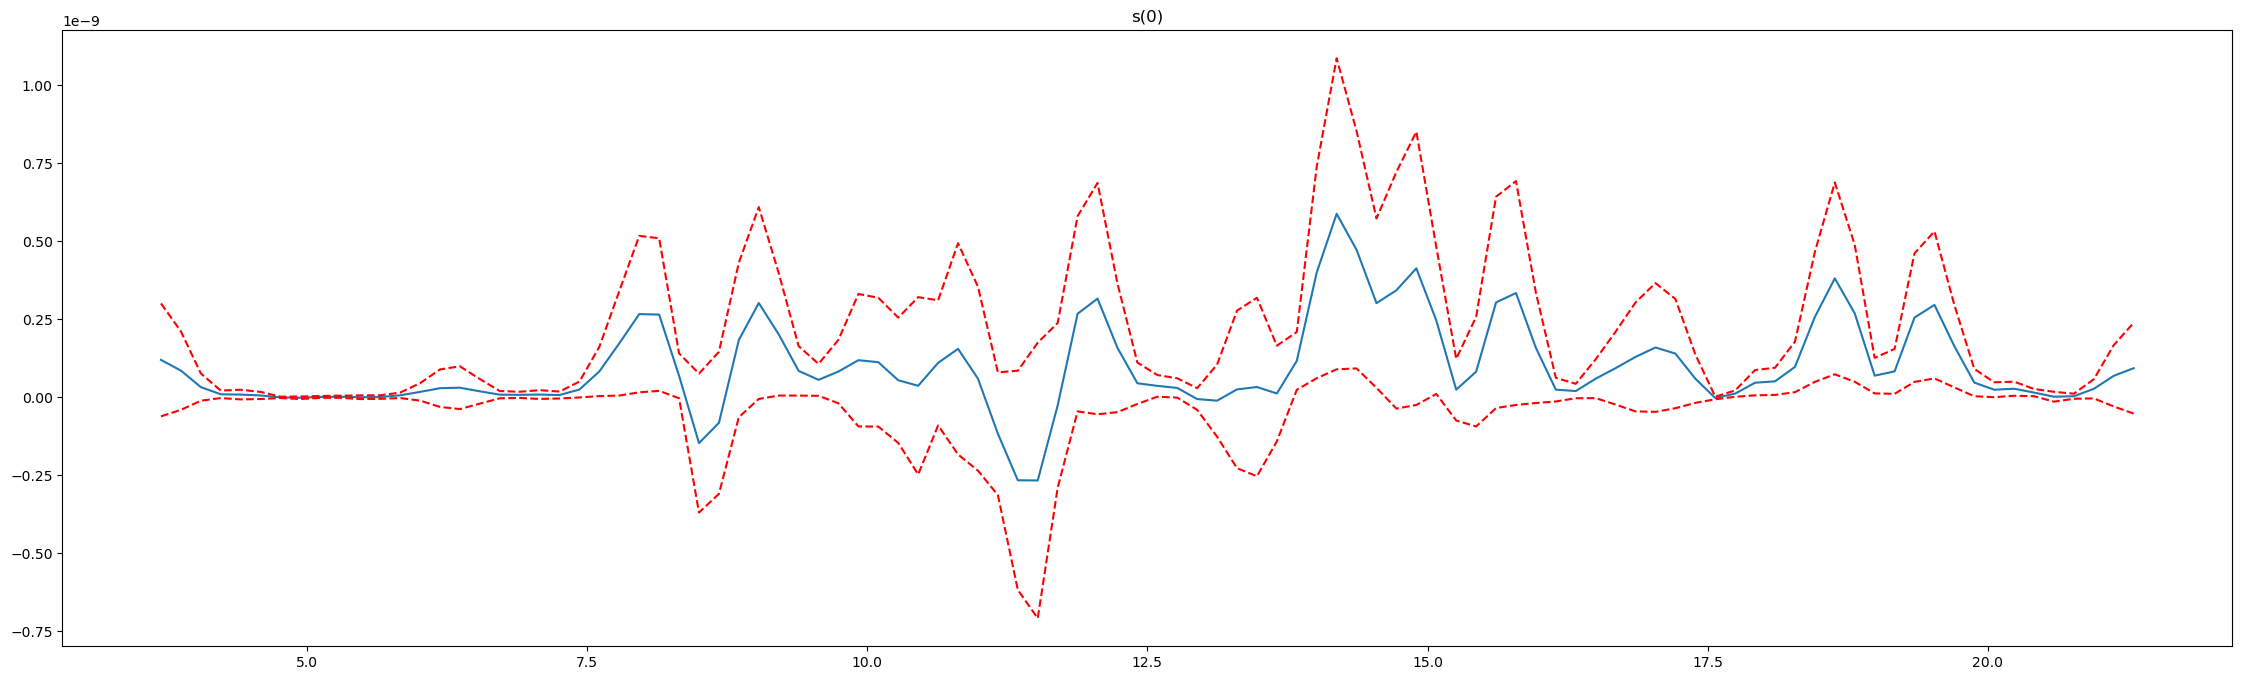

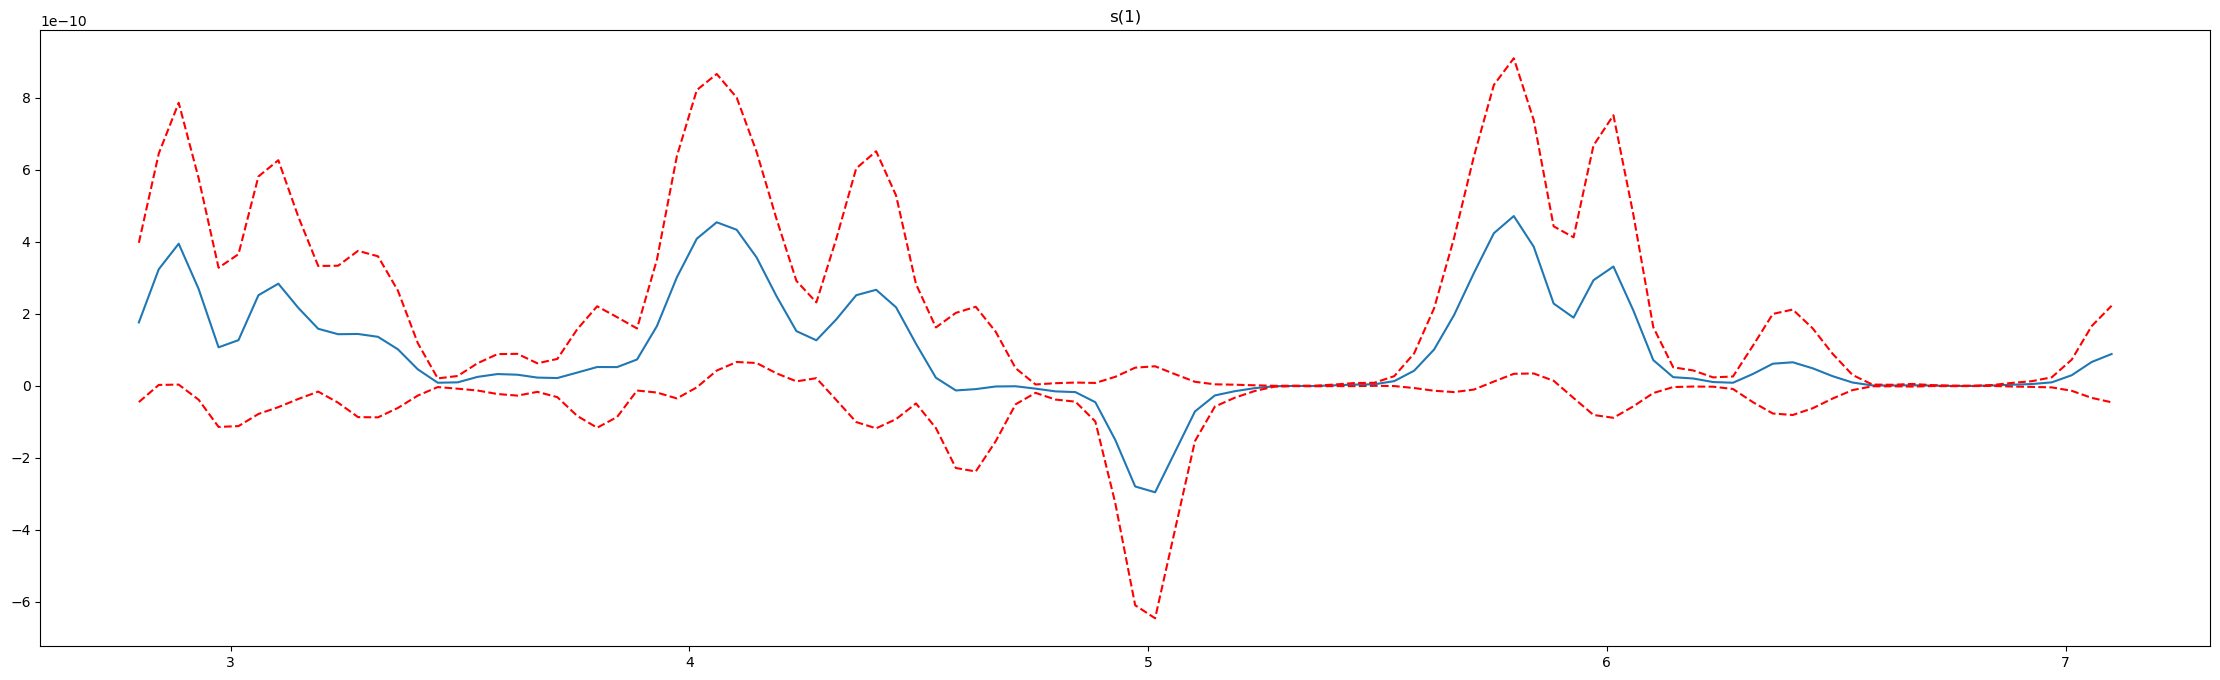

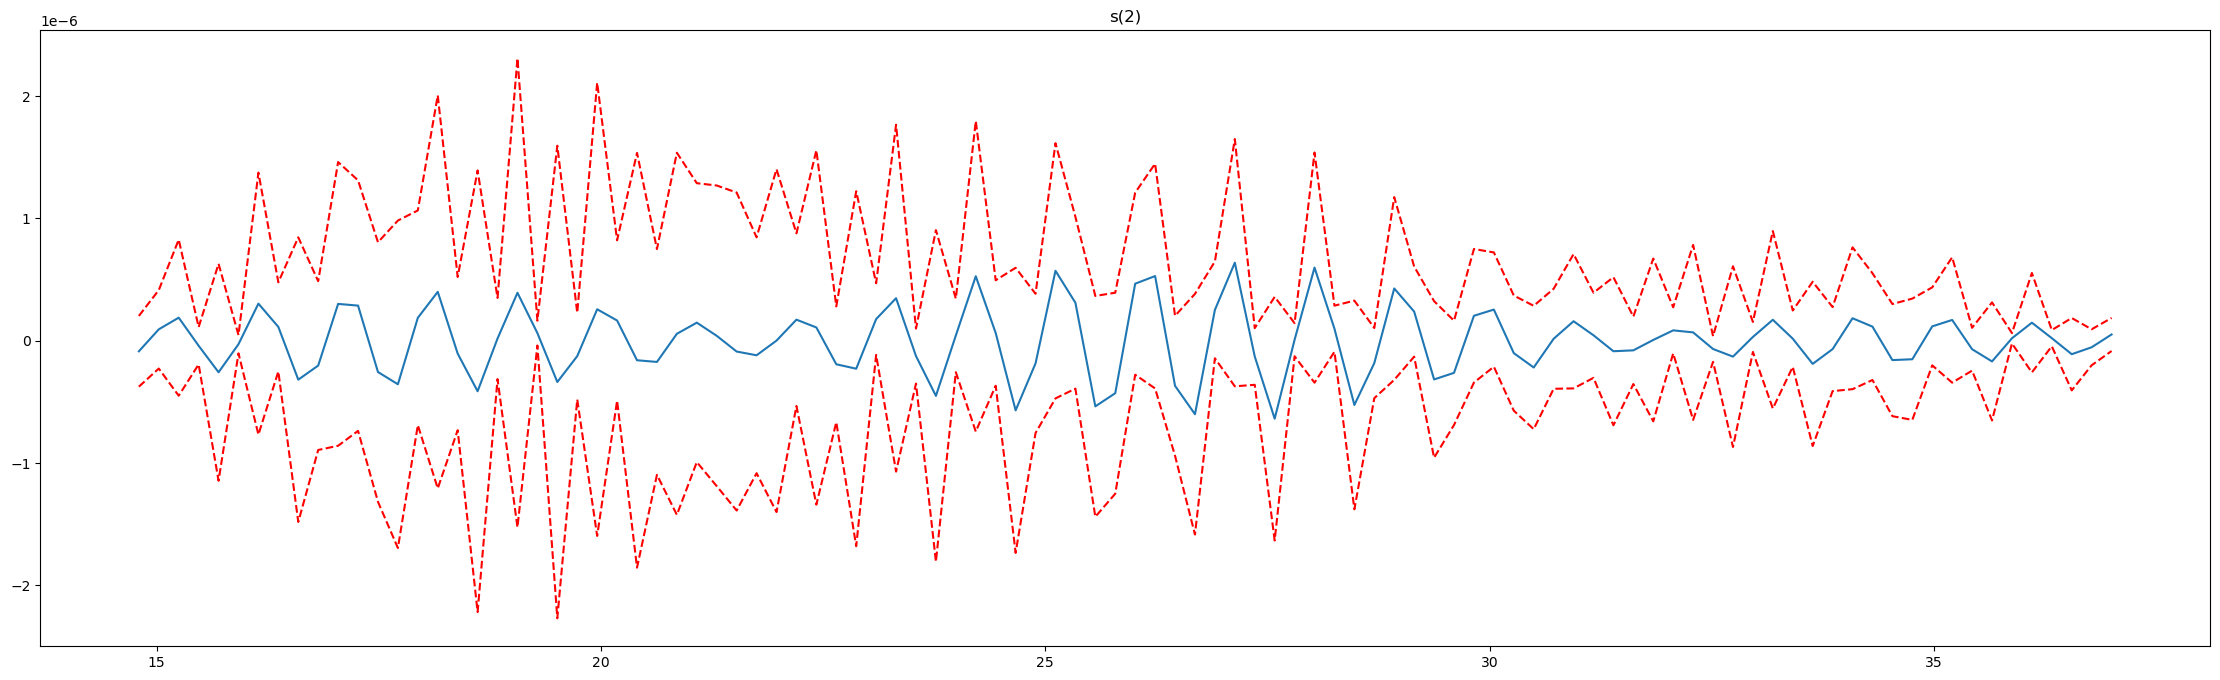

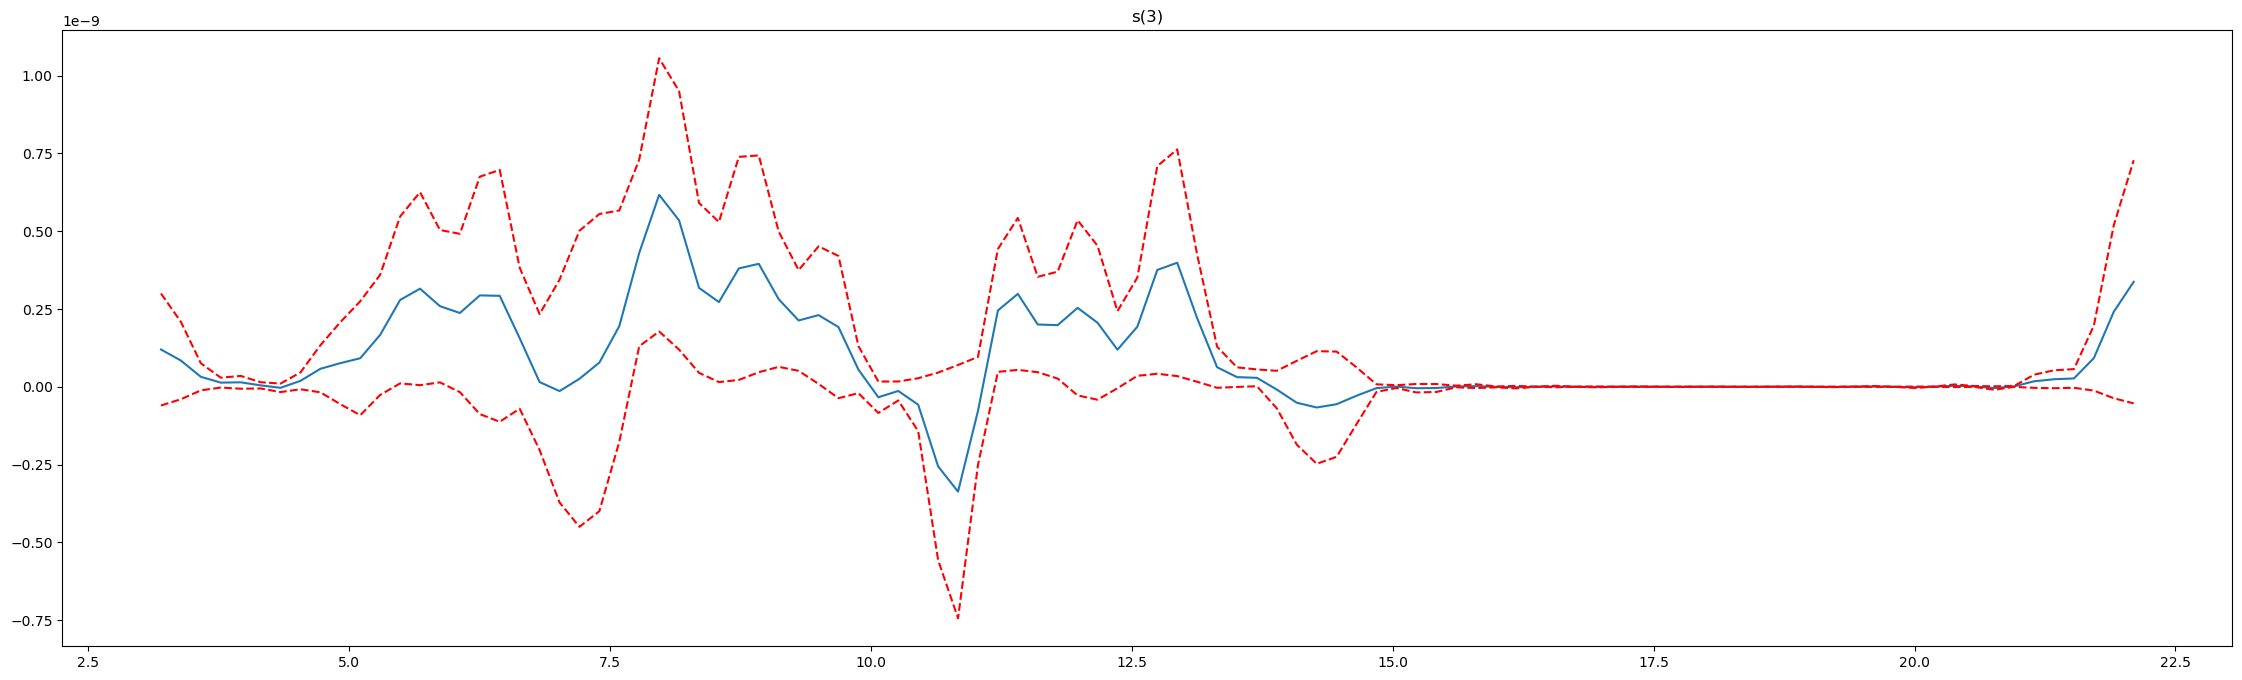

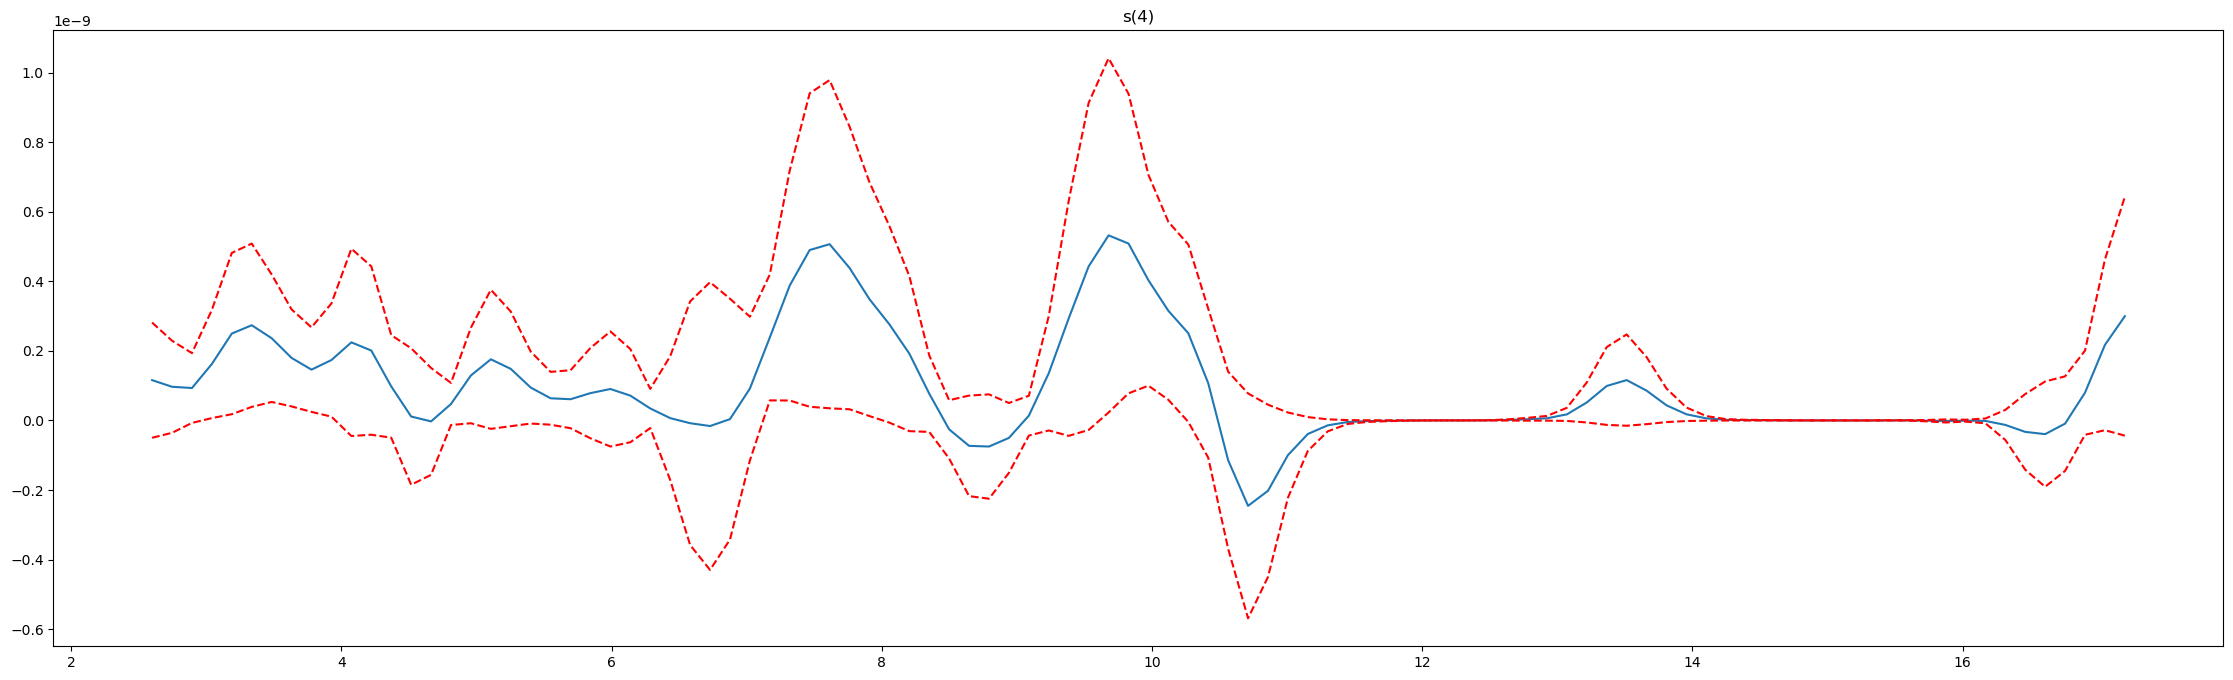

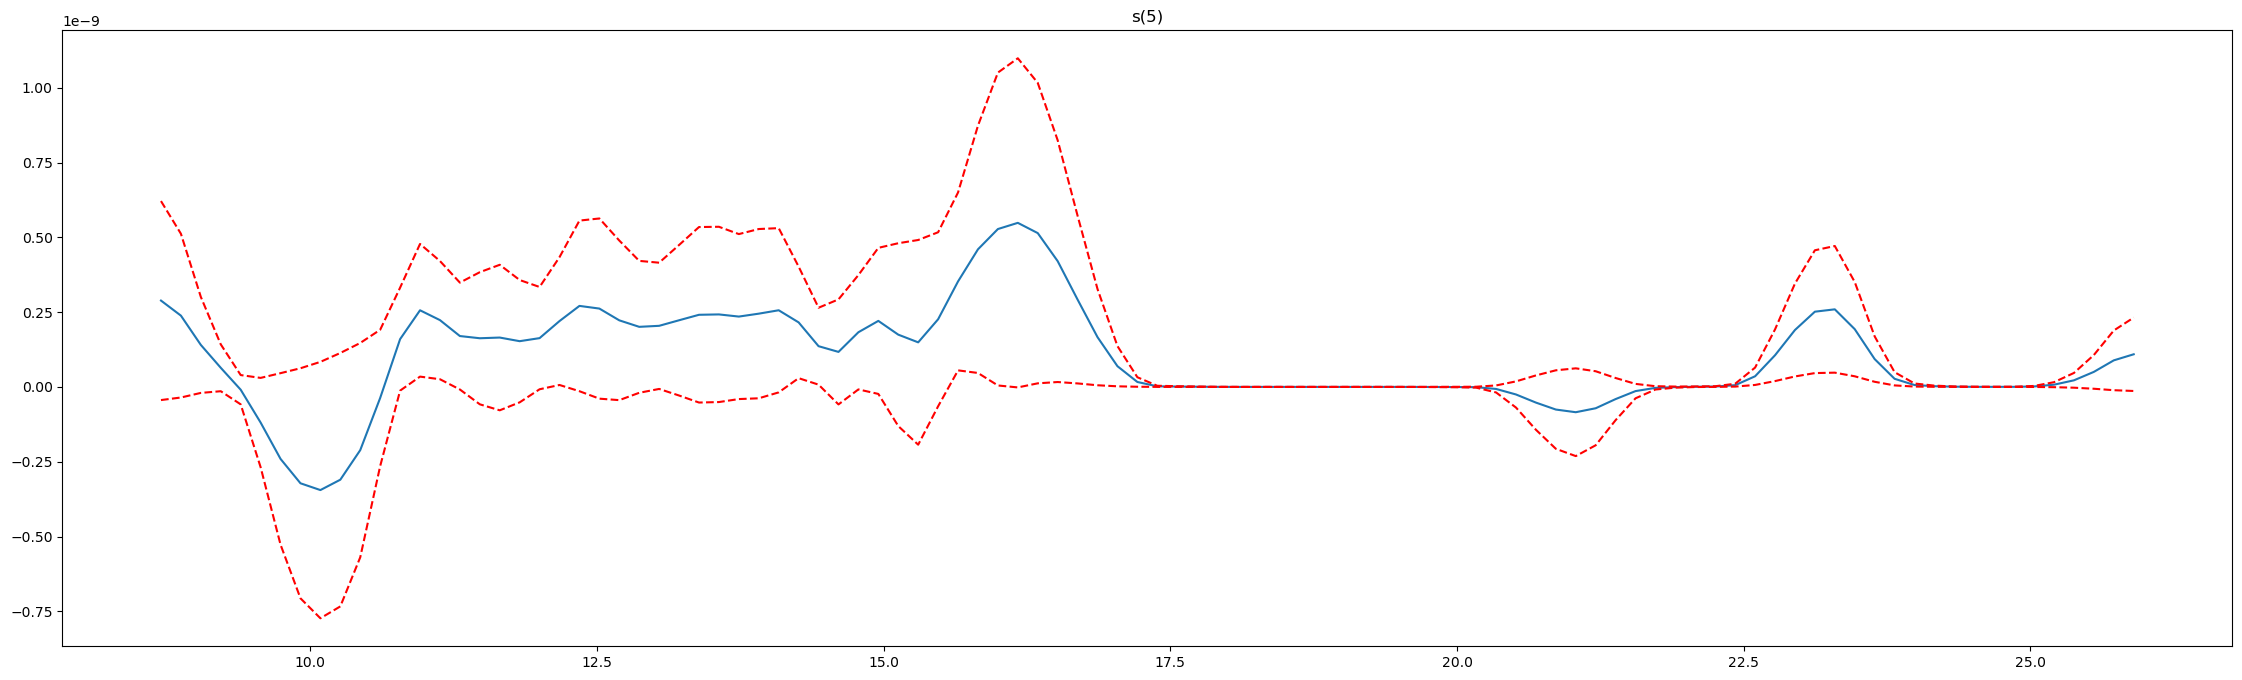

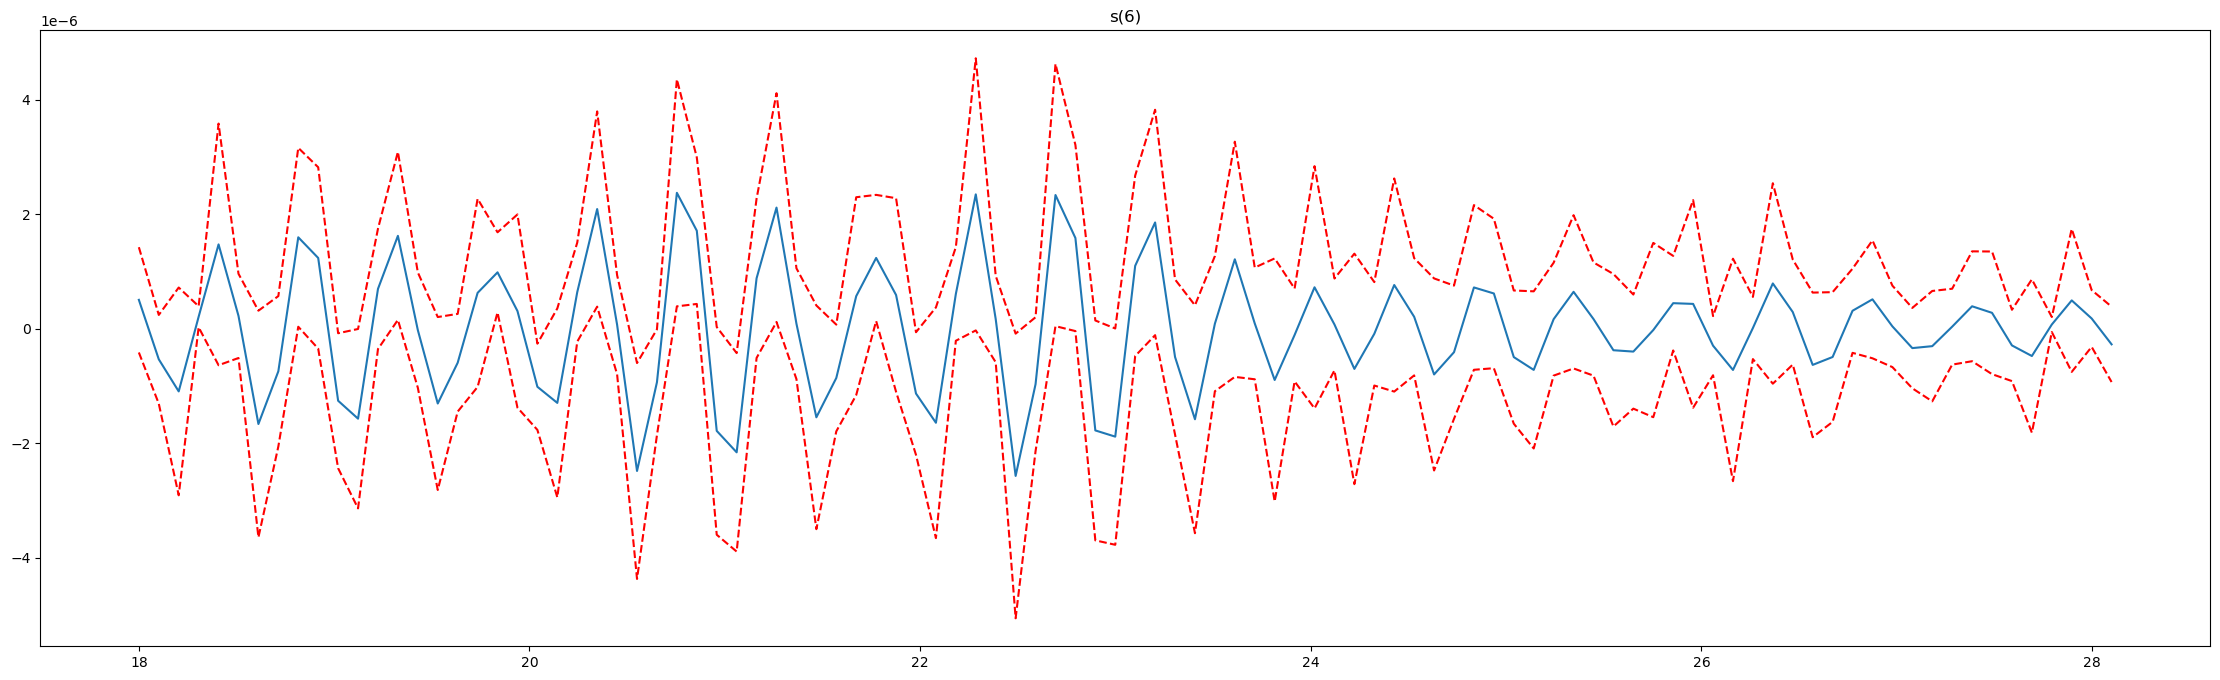

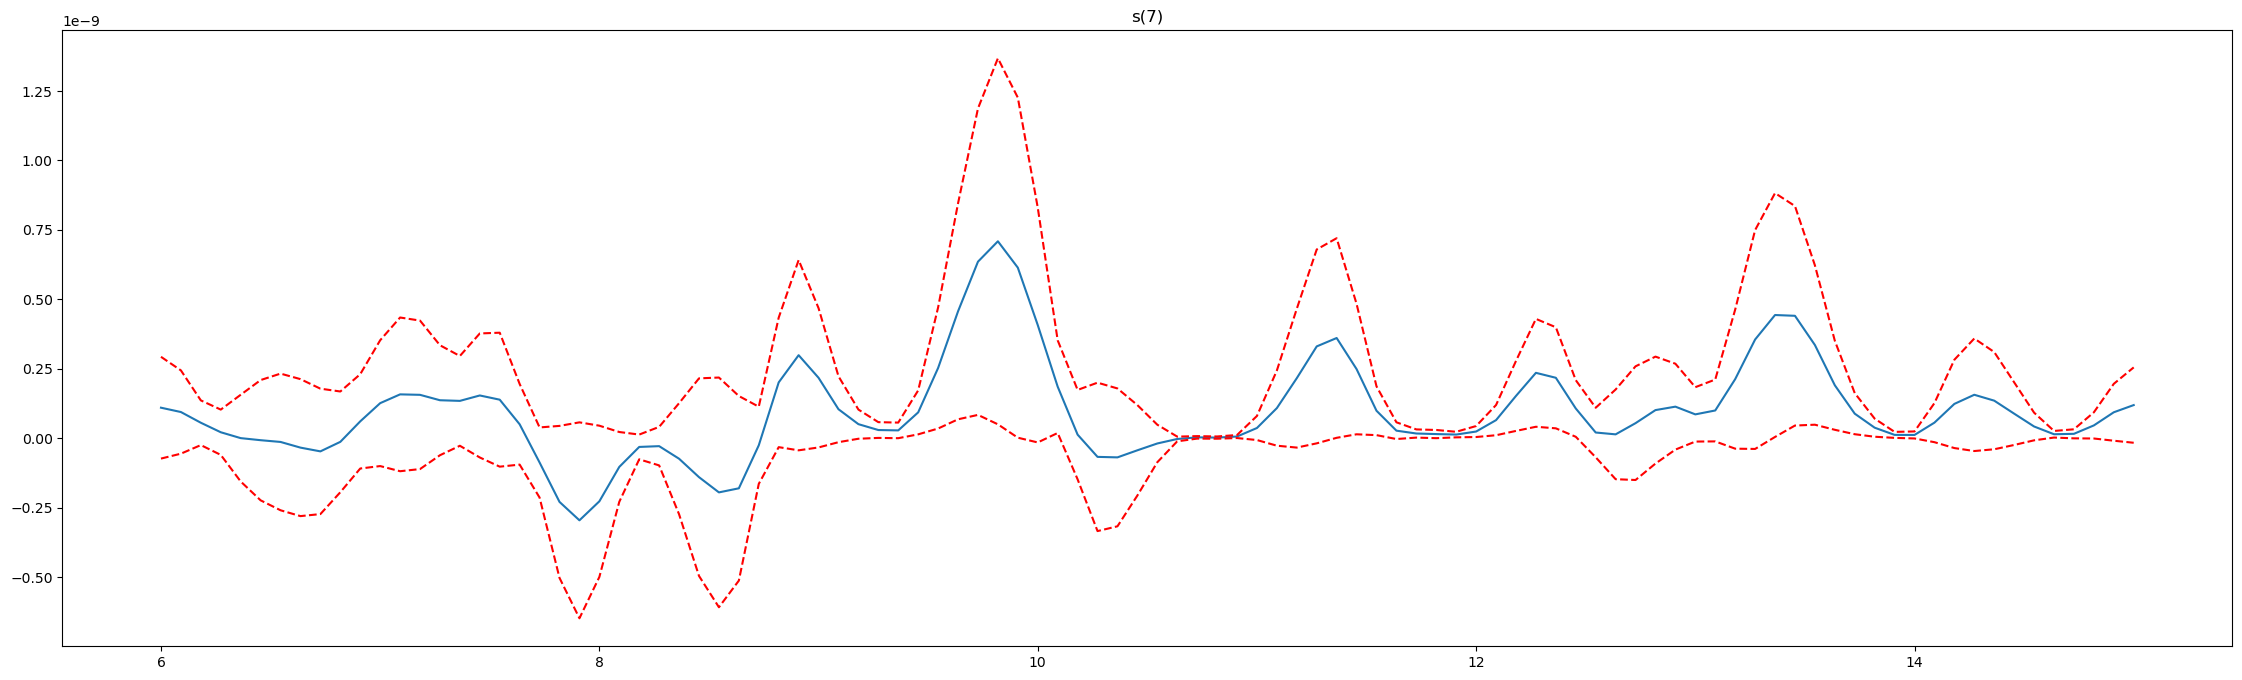

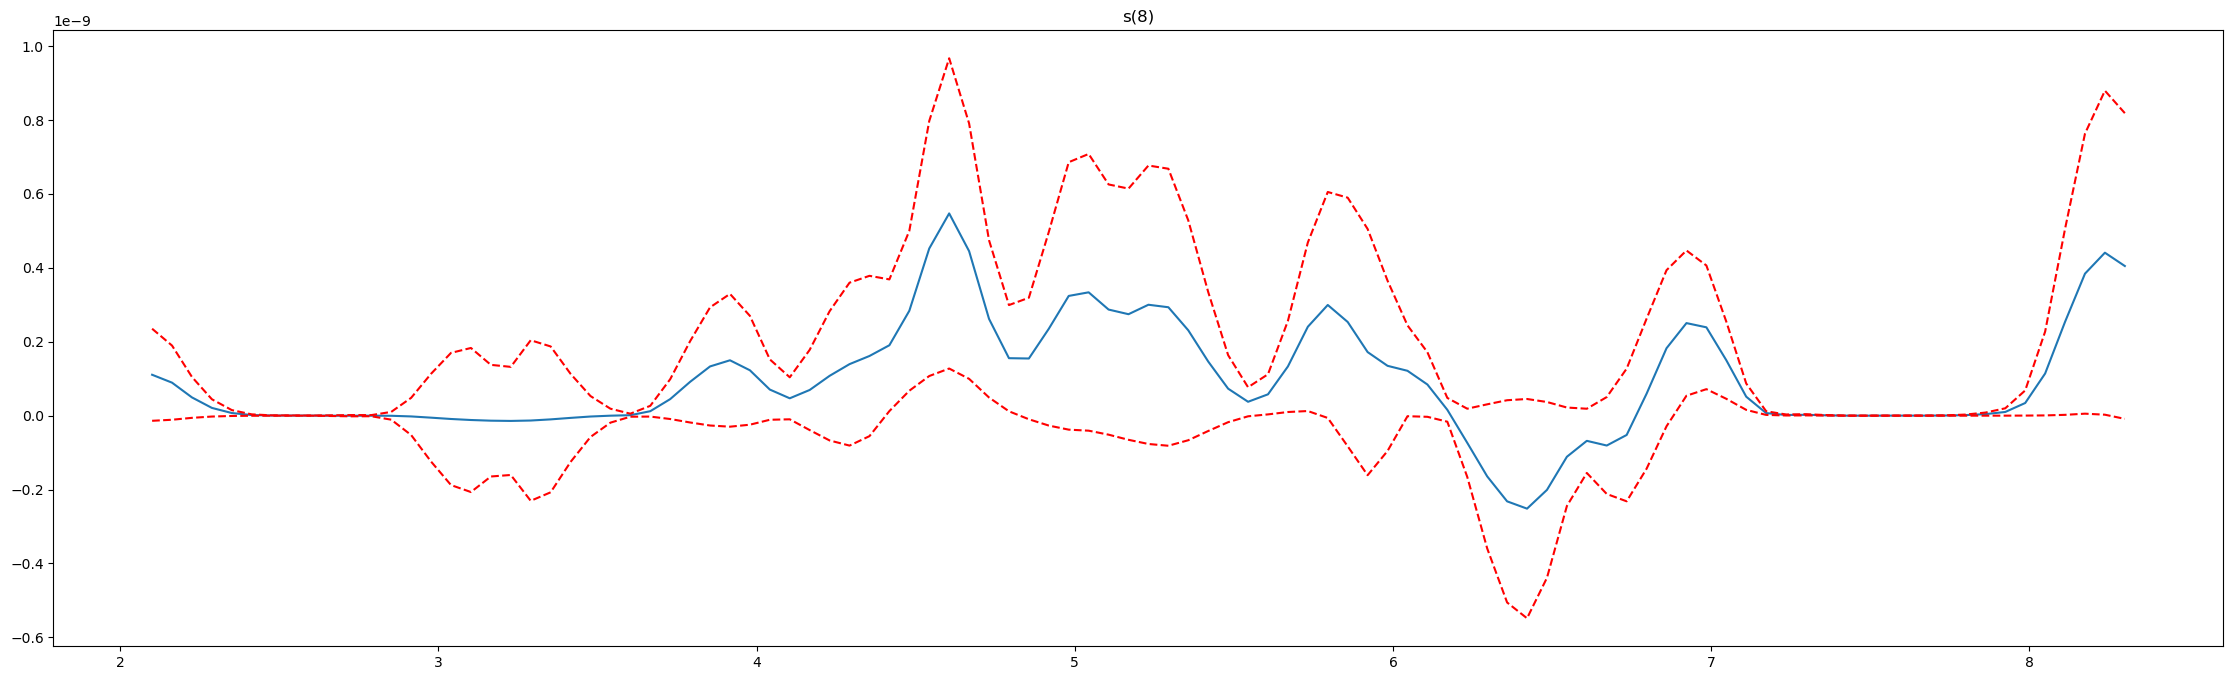

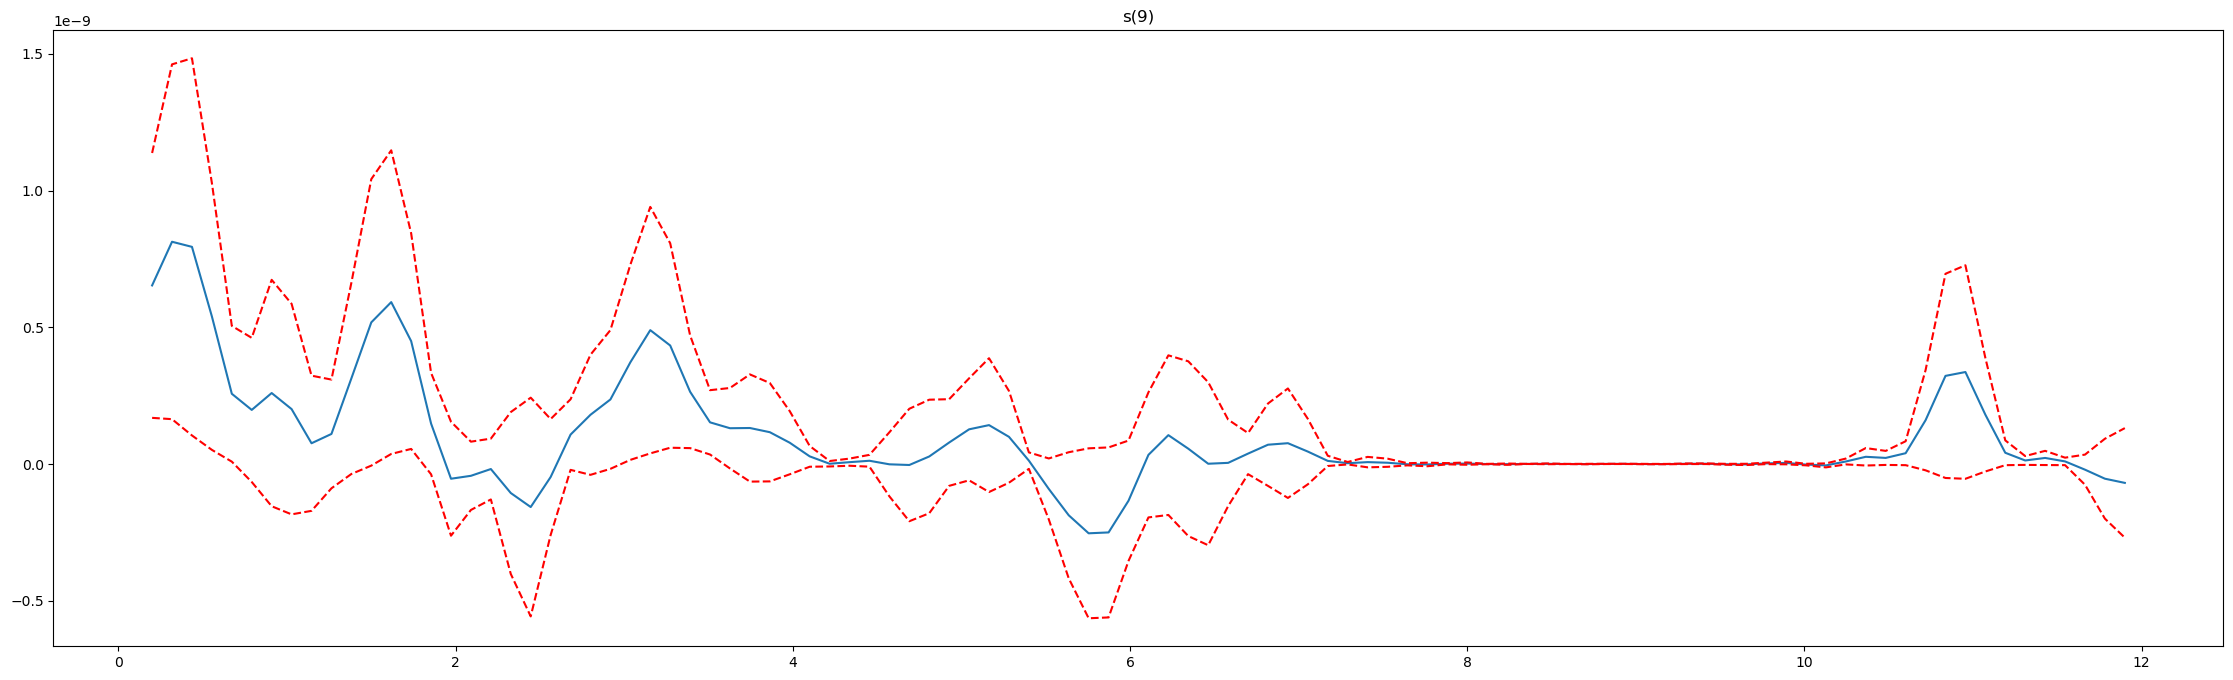

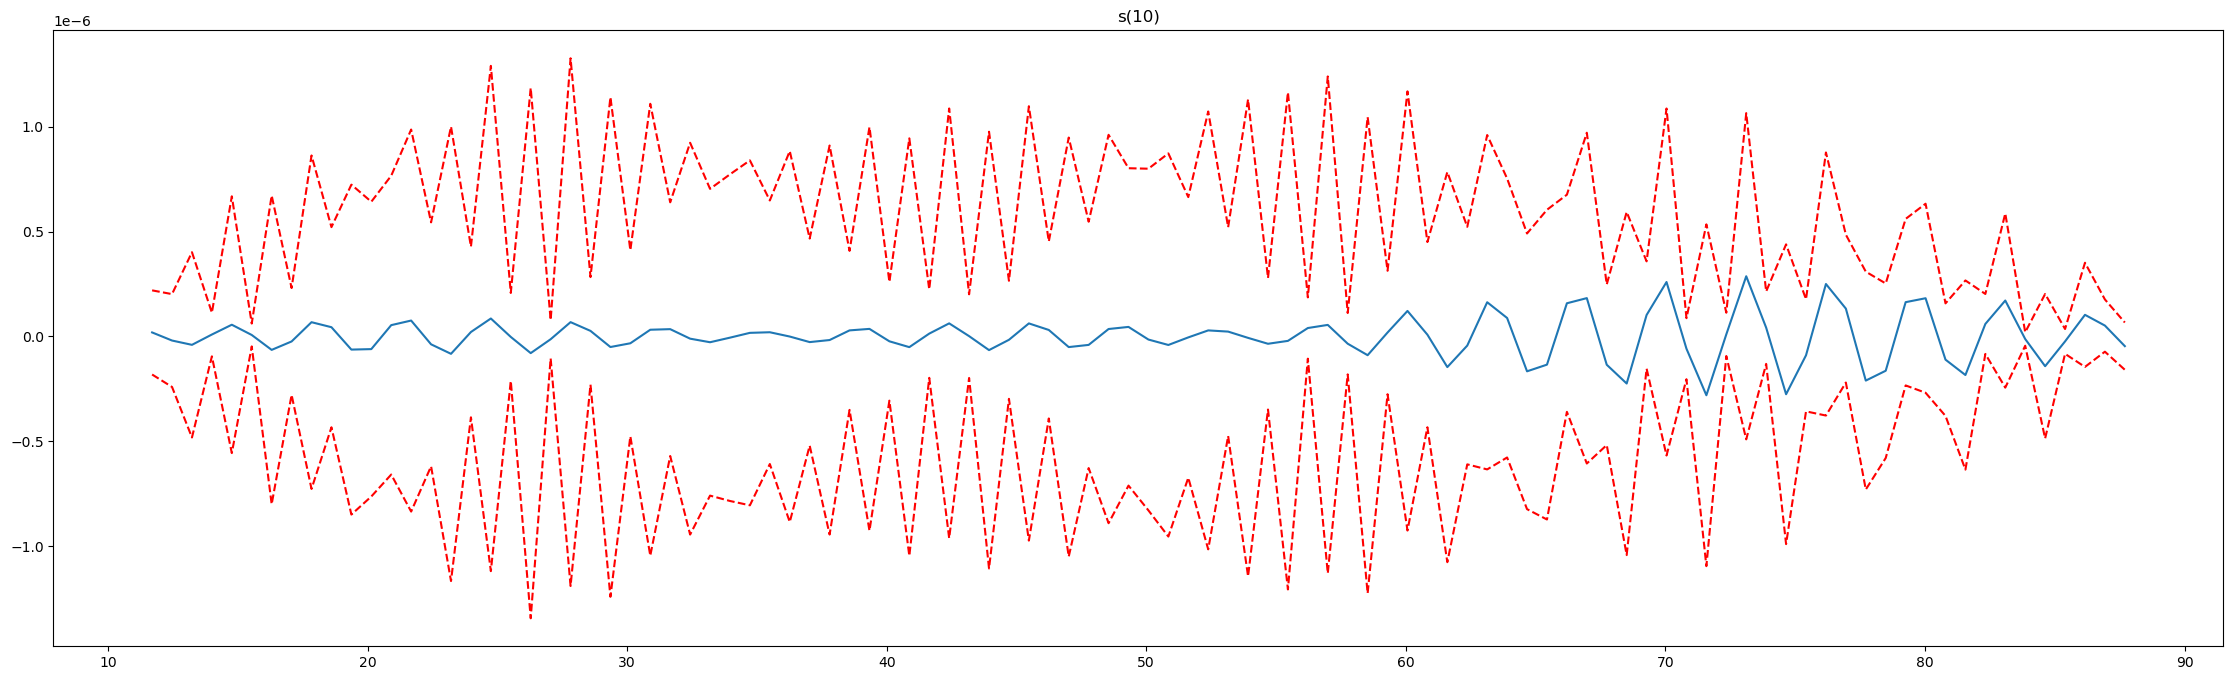

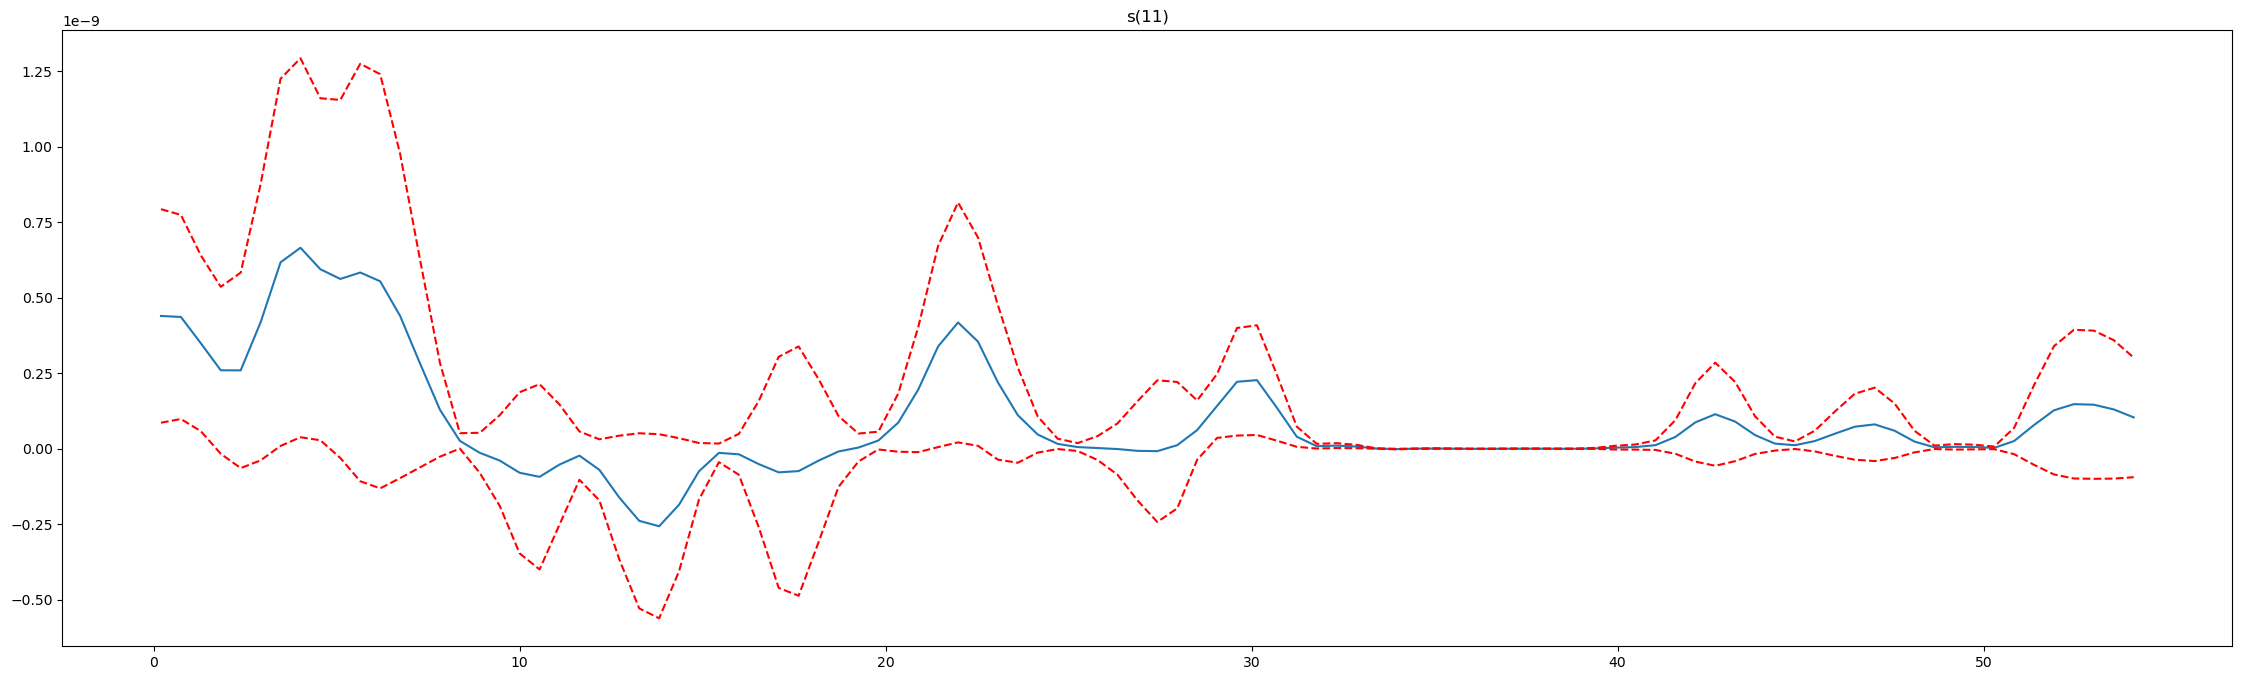

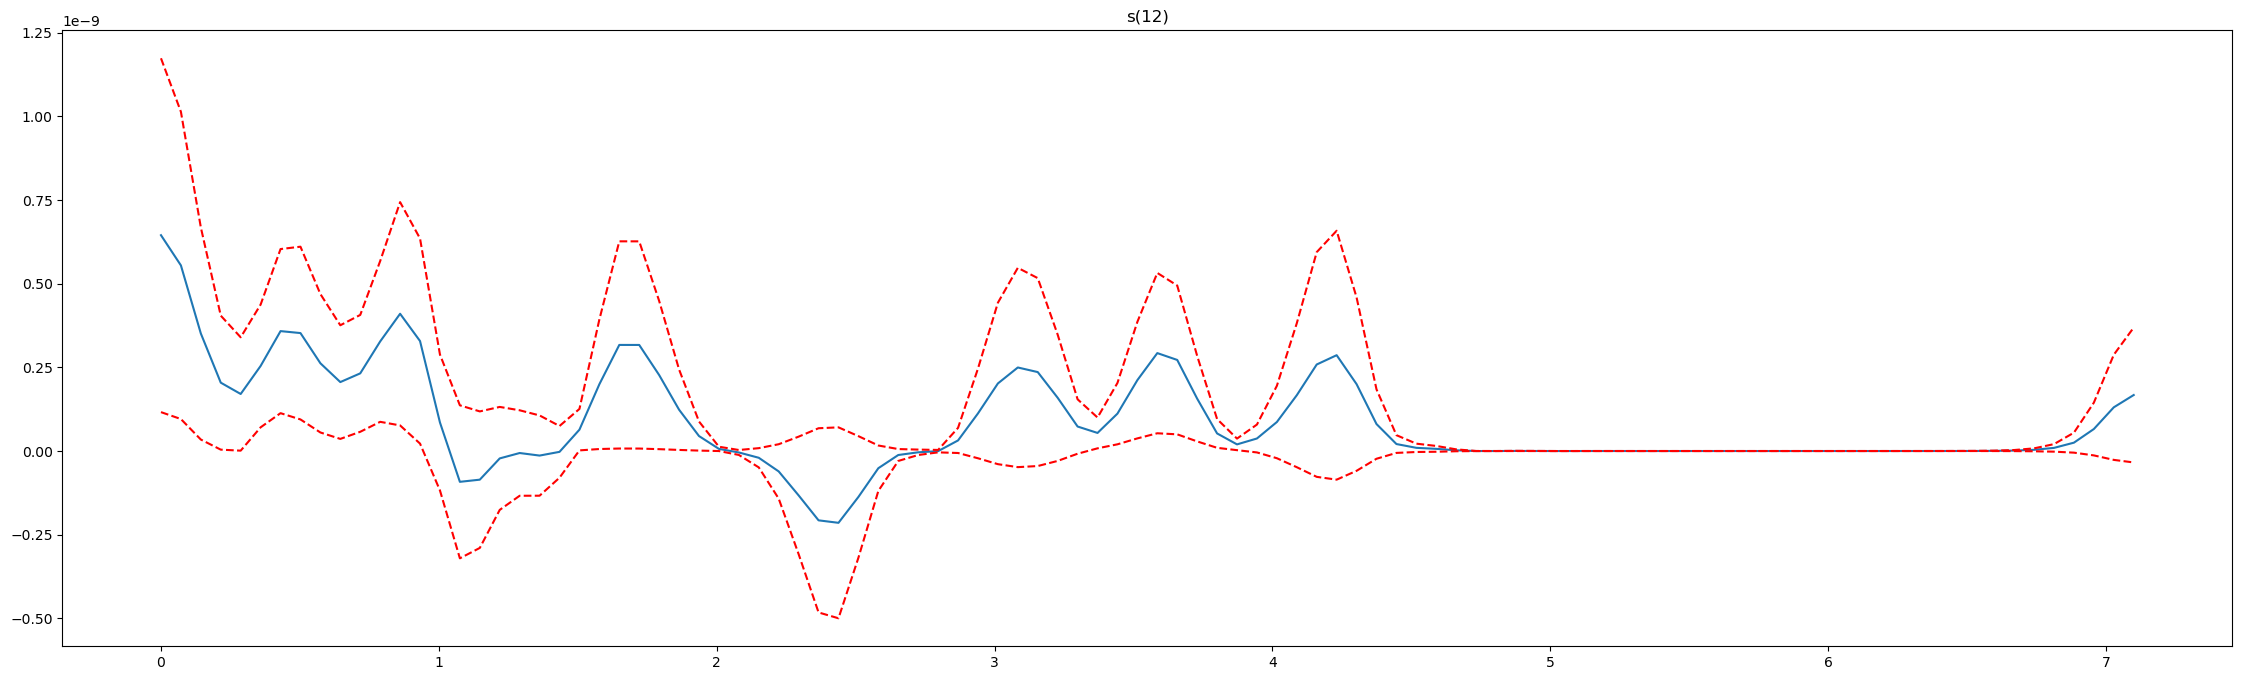

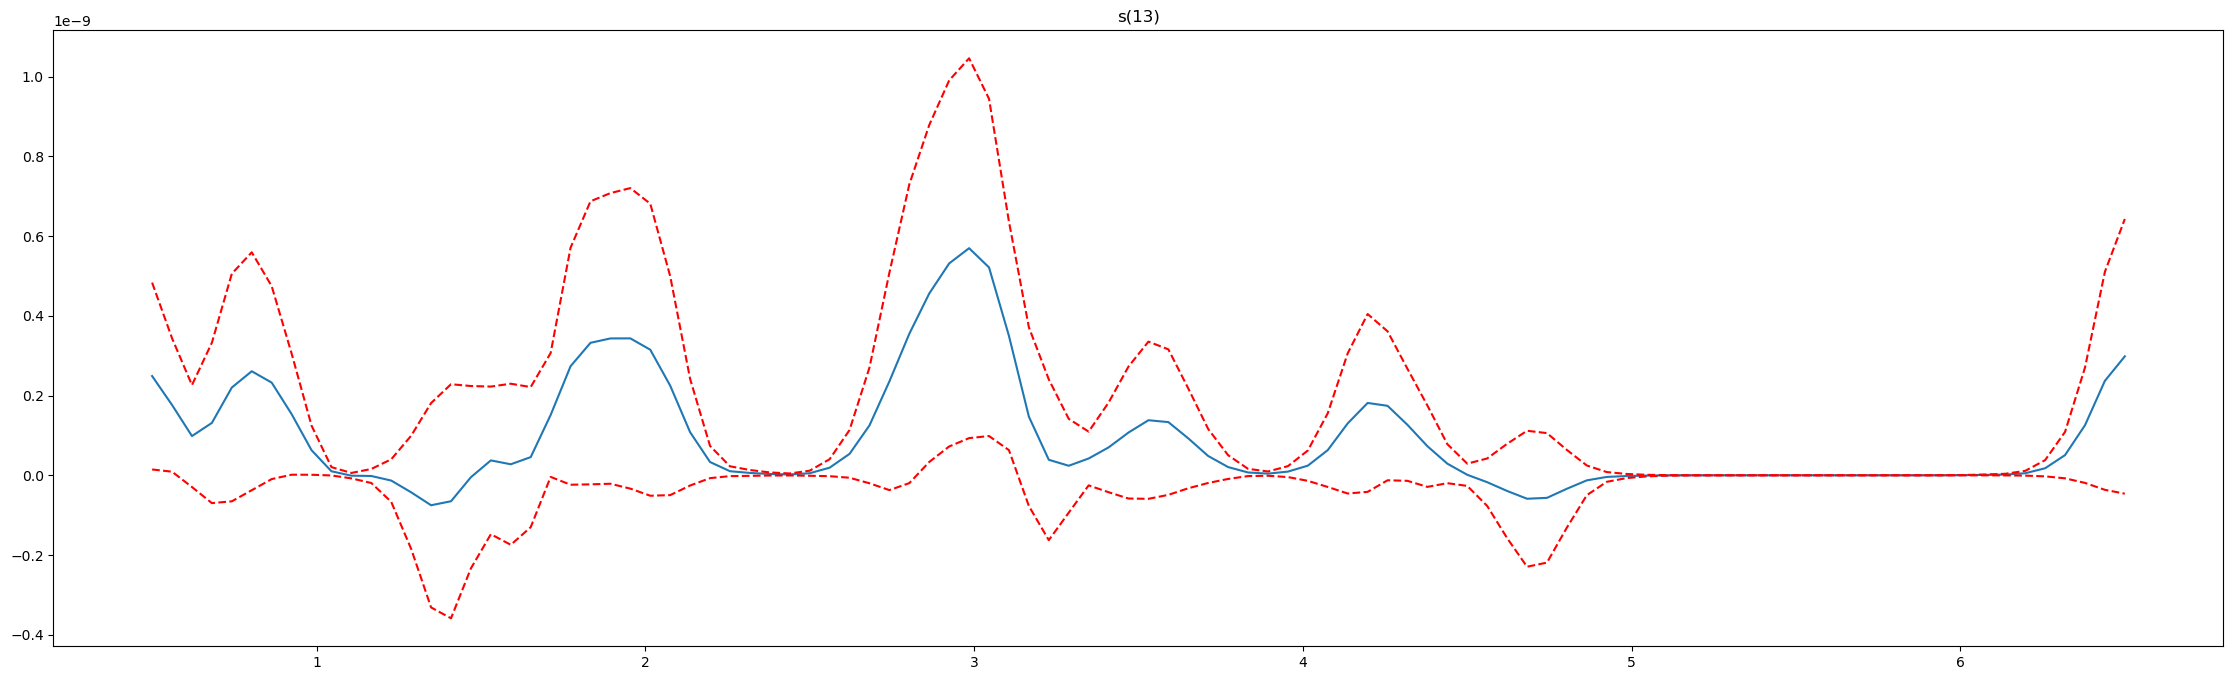

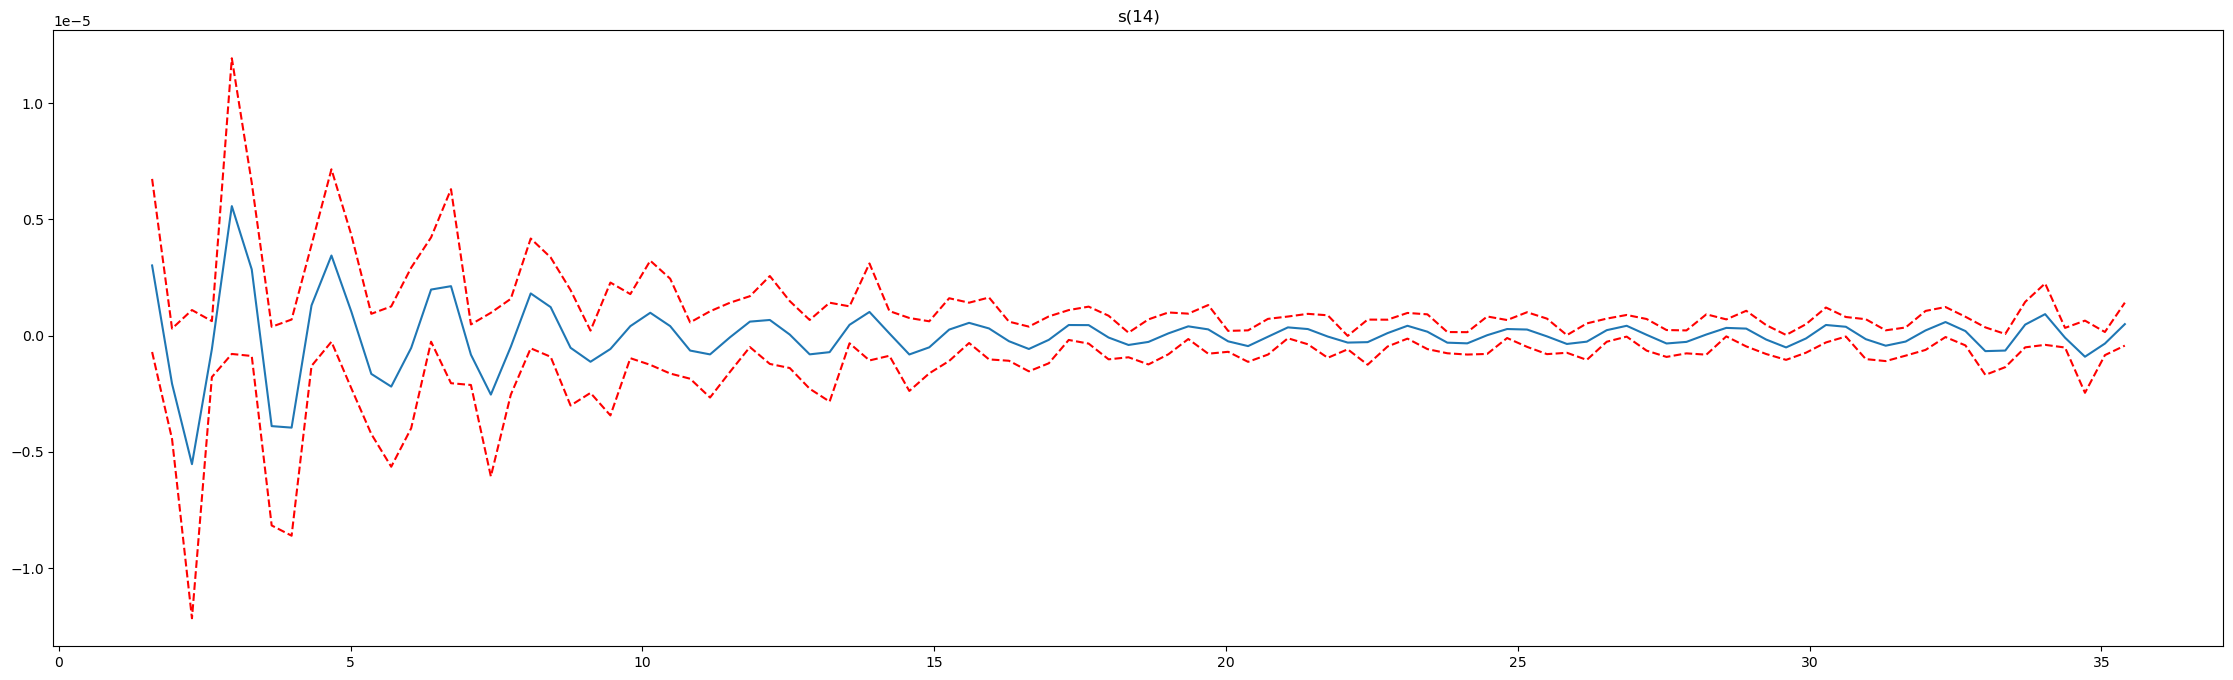

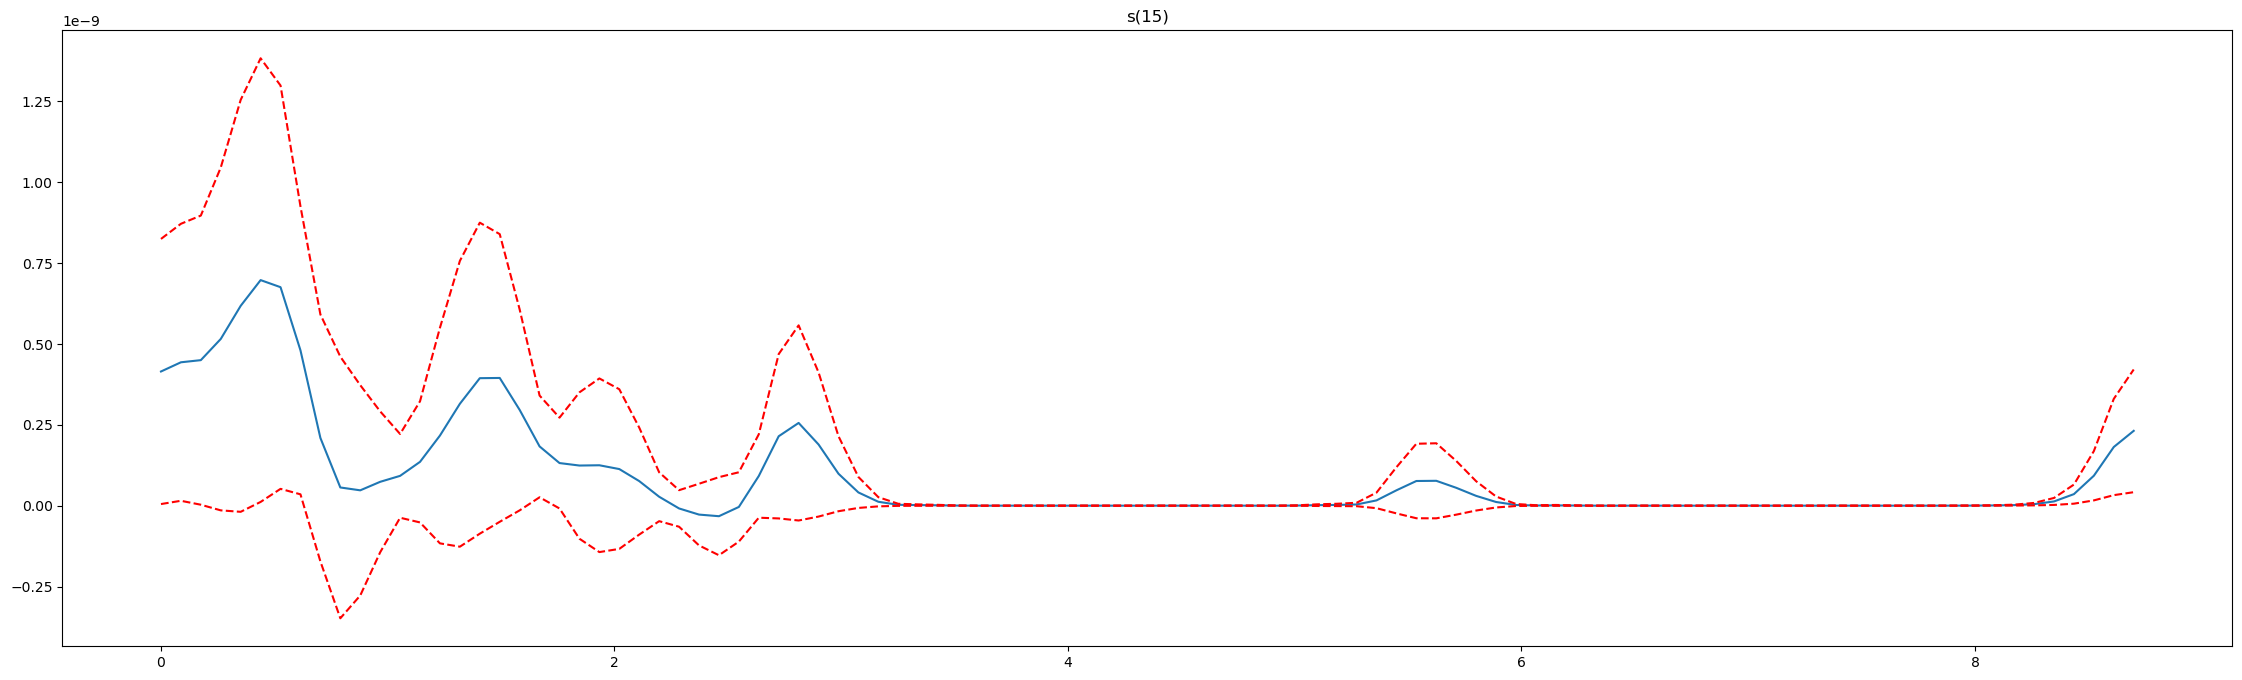

In [58]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

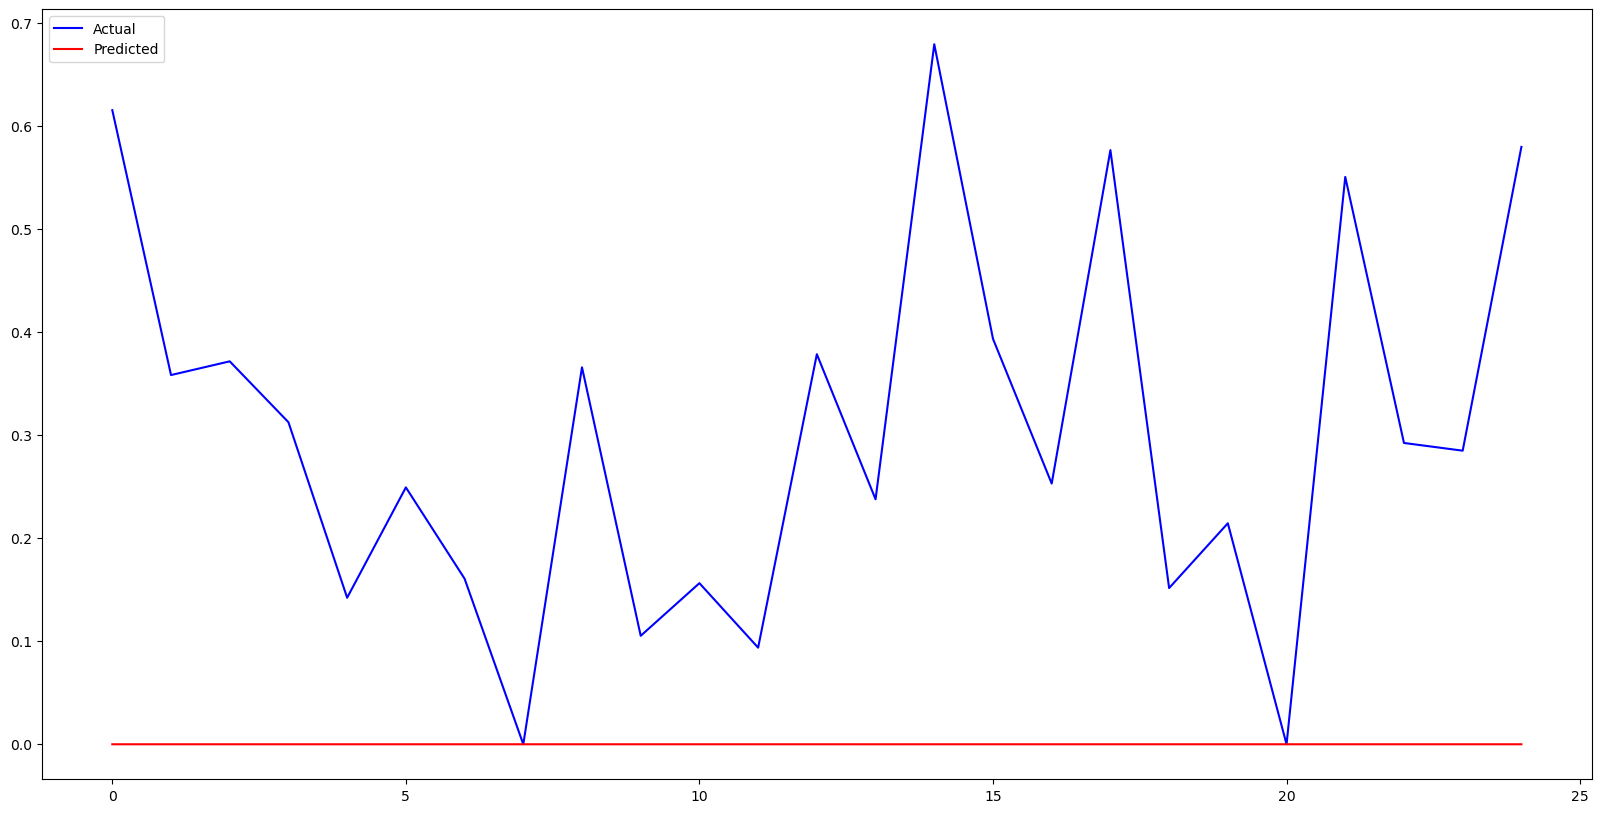

In [60]:
# plot both actual and predicted values on the same graph
y.plot(figsize=(20,10), color='blue', label='Actual')
plt.plot(gam.predict(X), color='red', label='Predicted')
plt.legend(loc='upper left')
plt.show()